QP to find the optimal battery operation that minimises the square distance of the residual demand. 3 months time horizon with peiodic boundary condition. No self discharging. Assume energy of 0.8 peak load hours with max power of 0.2 peak load. 

In [1]:
import pandas as pd
import numpy as np
import os 
import pickle

from cvxopt import matrix, solvers


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# battery params
SOCmax=0.8
Xmax=0.2

### compute residuals

In [3]:
# demand factor

file = open('../../preprocessing/s_demand.pkl', 'rb')

s_demand = pickle.load(file)

file.close()

s_demand.describe()



count    87672.000000
mean         0.672161
std          0.092507
min          0.423928
25%          0.601167
50%          0.677592
75%          0.741519
max          1.000000
Name: NEM, dtype: float64

In [4]:
# VRE capacity factor 

file1 = open('../../preprocessing/df_VRE.pkl', 'rb')

df_VRE = pickle.load(file1)

file1.close()

df_VRE.describe()

,NSA_wind,ADE_wind,SESA_wind,NQ_wind,CQ_wind,SWQ_wind,SEQ_wind,NNS_wind,NCEN_wind,SWNSW_wind,...,SEQ_pv,NNS_pv,NCEN_pv,SWNSW_pv,CAN_pv,CVIC_pv,NVIC_pv,MEL_pv,LV_pv,TAS_pv
count,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,...,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000
mean,0.487176,0.518950,0.482749,0.412358,0.399124,0.371925,0.298820,0.369941,0.410580,0.430320,...,0.223738,0.230826,0.224122,0.227533,0.221578,0.220851,0.213939,0.200579,0.191443,0.184123
std,0.250937,0.311564,0.294525,0.186893,0.209994,0.216614,0.232979,0.229998,0.264962,0.256515,...,0.292910,0.300694,0.294765,0.299780,0.302242,0.298624,0.293695,0.280950,0.271458,0.273811
min,0.000170,0.000000,0.000000,0.003431,0.000033,0.000023,0.000000,0.000073,0.000015,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.283203,0.239799,0.226274,0.268482,0.233753,0.195482,0.115597,0.175866,0.176217,0.215271,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.487286,0.532403,0.470042,0.412669,0.403292,0.361328,0.243690,0.352348,0.392946,0.422647,...,0.003167,0.004674,0.003822,0.004537,0.001356,0.001878,0.001367,0.001156,0.000933,0.000000
75%,0.689897,0.805126,0.736311,0.553285,0.558590,0.530006,0.435457,0.540617,0.625332,0.633184,...,0.476179,0.497844,0.476866,0.475440,0.440186,0.460181,0.428022,0.382439,0.353978,0.318978
max,0.990404,0.991690,0.991685,0.966683,0.980837,0.986573,0.991660,0.991663,0.991540,0.991620,...,0.921856,0.952050,0.945950,0.952181,0.986578,0.948800,0.957956,0.967111,0.982356,1.000000


In [5]:
# solution of bs=54

file2 = open('../copperplate/result_bootstrap.pkl', 'rb')

EF = pickle.load(file2)[54]

file2.close()

EF


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
NSA_wind,0.346978,3.128720e-01,3.051963e-01,2.919127e-01,2.901341e-01,2.833821e-01,2.720113e-01,2.530273e-01,2.416972e-01,2.305320e-01,2.235535e-01,2.070615e-01,1.930561e-01,1.804145e-01,1.682691e-01,1.438339e-01,1.215213e-01,8.674329e-02
ADE_wind,0.000000,4.485880e-03,9.109287e-03,1.482348e-02,1.746211e-02,1.114615e-02,8.709105e-03,6.115415e-03,2.938353e-03,2.310730e-03,8.991251e-05,9.982051e-11,1.094639e-09,4.031130e-10,4.378990e-04,2.868775e-03,4.671892e-03,1.514632e-18
SESA_wind,0.000000,1.588924e-13,1.579653e-12,1.462031e-12,4.146554e-12,2.832649e-12,4.799708e-11,5.096251e-11,8.162028e-12,1.557077e-11,2.513969e-11,7.028049e-12,1.042325e-10,1.765286e-11,5.203325e-11,5.135703e-11,4.181173e-10,0.000000e+00
NQ_wind,0.657934,6.536479e-01,6.428553e-01,6.271971e-01,6.128910e-01,5.727512e-01,5.448804e-01,5.088589e-01,4.814210e-01,4.595369e-01,4.424980e-01,4.162296e-01,3.927522e-01,3.700942e-01,3.489990e-01,3.104646e-01,2.713112e-01,2.426202e-01
CQ_wind,0.000000,2.064034e-13,2.550938e-12,3.762891e-12,3.481363e-11,3.057587e-02,4.771795e-02,5.899383e-02,6.289931e-02,6.036882e-02,5.751000e-02,4.963507e-02,4.355168e-02,4.345051e-02,4.316697e-02,4.134886e-02,4.173169e-02,3.133321e-02
SWQ_wind,0.087874,1.039016e-01,1.206573e-01,1.414270e-01,1.656472e-01,1.710470e-01,1.669089e-01,1.623480e-01,1.576193e-01,1.594705e-01,1.593780e-01,1.598713e-01,1.589992e-01,1.524977e-01,1.458227e-01,1.337937e-01,1.214722e-01,1.286401e-01
SEQ_wind,0.000000,8.261075e-14,9.987352e-13,1.322803e-12,4.808717e-12,4.122955e-12,7.775173e-11,1.096933e-10,1.981925e-11,3.373275e-11,4.746325e-11,1.253872e-11,1.555107e-10,2.547825e-11,7.911604e-11,1.054465e-10,7.009494e-10,3.502715e-02
NNS_wind,0.000000,1.771254e-13,1.929556e-12,1.944732e-12,5.123395e-12,3.771065e-12,6.794000e-11,8.591991e-11,1.480598e-11,2.798625e-11,4.445870e-11,1.266546e-11,1.874432e-10,2.631431e-11,6.360968e-11,4.956140e-11,2.349402e-10,-2.007837e-20
NCEN_wind,0.145447,1.563688e-01,1.538333e-01,1.522906e-01,1.454361e-01,1.278275e-01,1.151056e-01,9.880840e-02,8.894419e-02,8.032658e-02,7.146224e-02,5.671016e-02,4.465262e-02,3.916660e-02,3.479999e-02,2.587277e-02,1.867346e-02,5.068164e-19
SWNSW_wind,0.028195,1.743425e-02,2.250396e-02,2.614603e-02,1.417697e-02,3.839704e-11,2.952656e-10,1.558842e-10,1.933727e-11,2.650107e-11,3.500161e-11,7.663255e-12,9.243797e-11,1.231423e-11,3.001956e-11,2.608022e-11,1.360773e-10,-2.538527e-19


In [6]:
df_residual=pd.DataFrame(index=df_VRE.index, columns=EF.columns)
for col in df_residual.columns:
    df_residual[col]=s_demand.values-(df_VRE.values)@(EF[col].values[:32])
    
df_residual

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
AEST,,,,,,,,,,,,,,,,,,
2000-01-01 00:00:00,-0.304703,-0.284454,-0.281218,-0.273227,-0.251779,-0.209272,-0.178966,-0.132700,-0.098699,-0.071169,-0.047826,-0.007311,0.027298,0.057403,0.085468,0.138232,0.188289,0.242234
2000-01-01 01:00:00,-0.298746,-0.279653,-0.277313,-0.270498,-0.250605,-0.208438,-0.178490,-0.133269,-0.100190,-0.073649,-0.050848,-0.011530,0.022075,0.051345,0.078558,0.129703,0.178190,0.232700
2000-01-01 02:00:00,-0.308739,-0.289965,-0.288516,-0.282747,-0.264587,-0.223741,-0.194841,-0.151403,-0.119699,-0.094444,-0.072664,-0.035118,-0.002966,0.025154,0.051295,0.100457,0.147055,0.200531
2000-01-01 03:00:00,-0.310560,-0.292368,-0.291600,-0.286633,-0.270508,-0.231307,-0.203391,-0.161488,-0.130876,-0.106586,-0.085666,-0.049565,-0.018560,0.008559,0.033790,0.081291,0.126326,0.176573
2000-01-01 04:00:00,-0.304516,-0.287736,-0.287638,-0.283549,-0.269546,-0.232809,-0.206077,-0.165573,-0.135721,-0.112032,-0.091569,-0.056228,-0.025788,0.000737,0.025441,0.072002,0.116127,0.160652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-12-31 19:00:00,0.059028,0.073551,0.070566,0.069722,0.079956,0.098617,0.114594,0.142045,0.164040,0.180663,0.196237,0.222605,0.245012,0.268336,0.290224,0.330560,0.369103,0.402786
2009-12-31 20:00:00,0.020174,0.034257,0.029880,0.027451,0.038701,0.059970,0.076743,0.105041,0.127320,0.144467,0.160353,0.187416,0.210378,0.234192,0.256534,0.297833,0.337287,0.375468
2009-12-31 21:00:00,-0.002141,0.013622,0.007577,0.003652,0.015186,0.039346,0.056863,0.086194,0.108982,0.126928,0.143232,0.171276,0.195042,0.218976,0.241413,0.283054,0.322740,0.356450


In [7]:
df_residual.describe()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
count,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000
mean,-0.178878,-0.155194,-0.147322,-0.134161,-0.108178,-0.067070,-0.039017,0.002517,0.033537,0.058959,0.080643,0.117670,0.149179,0.177045,0.203005,0.251692,0.298221,0.335803
std,0.222879,0.214577,0.211247,0.206651,0.198863,0.188234,0.181530,0.172309,0.165692,0.160380,0.155912,0.148516,0.142407,0.137061,0.132203,0.123434,0.115486,0.112029
min,-1.122483,-1.047642,-1.015986,-0.968644,-0.893355,-0.790640,-0.734217,-0.655466,-0.599995,-0.555736,-0.516944,-0.450733,-0.393860,-0.342037,-0.293412,-0.204004,-0.119219,-0.087619
25%,-0.321616,-0.294876,-0.285622,-0.270678,-0.240383,-0.192943,-0.160696,-0.113411,-0.078071,-0.049171,-0.024614,0.017047,0.052551,0.083858,0.112895,0.167379,0.218709,0.260360
50%,-0.172636,-0.150913,-0.143875,-0.132268,-0.107900,-0.067477,-0.040548,0.000052,0.030567,0.055687,0.077203,0.114081,0.145463,0.173174,0.199140,0.247393,0.293477,0.331950
75%,-0.028362,-0.009858,-0.004349,0.005373,0.025989,0.058914,0.082139,0.117064,0.143440,0.165217,0.183666,0.215543,0.242995,0.267184,0.289770,0.332792,0.374239,0.408442
max,0.619022,0.624168,0.626375,0.629953,0.636556,0.643569,0.650214,0.661827,0.670470,0.678199,0.684221,0.695381,0.704782,0.713639,0.722018,0.737825,0.752817,0.781360


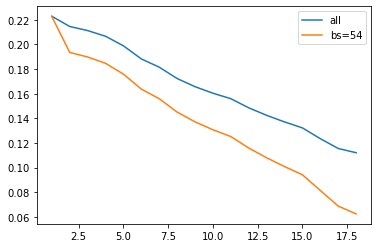

In [8]:
plt.plot(df_residual.std(), label='all')
plt.plot(np.sqrt(EF.loc['sigma_sq']), label='bs=54')
plt.legend()
plt.show()

### battery QP

In [9]:
years=df_residual.index.year.unique().to_list()
month_segments=[[1,3], [4,6], [7,9], [10,12]]


# initialise output
df=df_residual.copy()


df_charge=pd.DataFrame(index=df.index, columns=df.columns)
df_charge.index.name='AEST'


for col in df.columns:
#for col in df.columns[:2]: #for testing

    for year in years:
    #for year in [2000]: # for testing
        for month_segment in month_segments:
            # select time horizon
            s_rdemand=df.loc[(df.index.year==year) & (df.index.month>=month_segment[0]) &
                            (df.index.month<=month_segment[1]), col].copy()

            ##############
            # quadratic objective
            ##############
            T=len(s_rdemand)
            Q=matrix(np.eye(T)) # Q martrix
            p=matrix(s_rdemand.values) # p vector

            ##############
            # Inequality constraints
            ##############

            ### power / charge rate constraints
            l=np.array([])
            u=np.array([])


            for r in s_rdemand.values:
                if r>0:
                    l=np.append(l, max(-Xmax, -r))
                    u=np.append(u, 0)
                else:
                    l=np.append(l, 0)
                    u=np.append(u, min(Xmax, -r))

            A_rate=np.vstack([np.eye(T), -np.eye(T)])
            b_rate=np.concatenate([u, -l])


            ### SOC constraints

            #no self-discharge
            M_ltri=np.tril(np.ones((len(s_rdemand),len(s_rdemand)))) 
            A_soc=np.vstack([M_ltri, -M_ltri]) 


            # periodic boundary condition with 0.5 time SOCmax on either end
            b1=np.repeat(SOCmax/2, T)
            b2=np.repeat(SOCmax/2, T)
            b1[-1]=0.0000001 # add an epsilon to avoid equality
            b2[-1]=0.0000001 # add an epsilon to avoid equality with the above

            b_soc=np.concatenate([b1, b2])

            ### combine
            A=matrix(np.vstack([A_rate, A_soc]))
            b=matrix(np.concatenate([b_rate, b_soc]))

            sol=solvers.qp(Q, p, G=A,h=b)

            v_charge=np.array(sol['x']).ravel()
            v_shifted=s_rdemand.values+v_charge


            # update
            df.loc[(df.index.year==year) & (df.index.month>=month_segment[0]) &
                            (df.index.month<=month_segment[1]), col]=v_shifted
            df_charge.loc[(df_charge.index.year==year) & (df_charge.index.month>=month_segment[0]) &
                            (df_charge.index.month<=month_segment[1]), col]=v_charge

            print(col, year, month_segment, SOCmax/2+v_charge.sum())





     pcost       dcost       gap    pres   dres
 0: -3.1463e+00 -2.3221e+03  1e+04  4e+00  5e-12
 1: -3.1259e+00 -1.3843e+03  2e+03  2e-01  2e-12
 2: -2.8396e+00 -3.1454e+02  3e+02  2e-02  9e-12
 3: -3.2844e+00 -6.3408e+01  6e+01  4e-03  3e-12
 4: -4.4103e+00 -3.1804e+01  3e+01  8e-04  8e-12
 5: -5.3883e+00 -1.6951e+01  1e+01  2e-04  4e-11
 6: -5.8482e+00 -1.4888e+01  9e+00  9e-05  3e-10
 7: -6.4959e+00 -1.0061e+01  4e+00  2e-05  1e-08
 8: -6.6882e+00 -9.1060e+00  2e+00  5e-06  4e-09
 9: -7.0199e+00 -7.6804e+00  7e-01  1e-06  3e-07
10: -7.1099e+00 -7.3406e+00  2e-01  3e-07  5e-08
11: -7.1533e+00 -7.1905e+00  4e-02  3e-08  1e-07
12: -7.1597e+00 -7.1697e+00  1e-02  4e-09  2e-08
13: -7.1612e+00 -7.1651e+00  4e-03  1e-09  5e-09
14: -7.1617e+00 -7.1637e+00  2e-03  3e-10  2e-09
15: -7.1621e+00 -7.1624e+00  3e-04  4e-11  3e-10
16: -7.1622e+00 -7.1622e+00  3e-05  3e-12  5e-11
17: -7.1622e+00 -7.1622e+00  3e-07  3e-14  6e-11
Optimal solution found.
1 2000 [1, 3] 0.40000009981936285
     pcost  

15: -7.7984e+00 -7.7984e+00  4e-06  3e-14  1e-11
Optimal solution found.
1 2002 [1, 3] 0.40000009932231106
     pcost       dcost       gap    pres   dres
 0: -4.7213e+00 -2.3771e+03  1e+04  4e+00  1e-11
 1: -4.2771e+00 -1.4336e+03  2e+03  2e-01  1e-12
 2: -3.3669e+00 -3.1414e+02  3e+02  3e-02  8e-12
 3: -3.7288e+00 -6.3096e+01  6e+01  4e-03  8e-13
 4: -4.7176e+00 -4.0626e+01  4e+01  1e-03  7e-12
 5: -5.6533e+00 -1.8488e+01  1e+01  3e-04  2e-11
 6: -6.4359e+00 -1.5063e+01  9e+00  5e-05  1e-10
 7: -6.9267e+00 -1.1026e+01  4e+00  2e-05  2e-09
 8: -7.2884e+00 -9.0504e+00  2e+00  5e-06  9e-08
 9: -7.4929e+00 -8.0941e+00  6e-01  1e-06  2e-07
10: -7.5786e+00 -7.7317e+00  2e-01  4e-08  6e-08
11: -7.6098e+00 -7.6371e+00  3e-02  4e-09  2e-07
12: -7.6166e+00 -7.6175e+00  9e-04  1e-11  3e-08
13: -7.6168e+00 -7.6170e+00  2e-04  1e-12  2e-09
14: -7.6169e+00 -7.6169e+00  4e-06  7e-15  5e-11
Optimal solution found.
1 2002 [4, 6] 0.4000000995009971
     pcost       dcost       gap    pres   dres
 0: -

14: -9.7444e+00 -9.7447e+00  3e-04  2e-15  3e-10
15: -9.7445e+00 -9.7445e+00  1e-05  2e-15  3e-11
16: -9.7445e+00 -9.7445e+00  1e-07  1e-15  7e-10
Optimal solution found.
1 2004 [4, 6] 0.4000000999934889
     pcost       dcost       gap    pres   dres
 0: -5.6134e+00 -2.4102e+03  1e+04  4e+00  8e-12
 1: -5.5789e+00 -1.4588e+03  2e+03  2e-01  1e-12
 2: -5.7035e+00 -3.2001e+02  3e+02  2e-02  6e-12
 3: -6.7370e+00 -7.0806e+01  7e+01  4e-03  1e-12
 4: -9.2644e+00 -3.2990e+01  2e+01  8e-04  2e-11
 5: -1.0349e+01 -3.0055e+01  2e+01  4e-04  4e-11
 6: -1.1594e+01 -2.0243e+01  9e+00  1e-04  3e-09
 7: -1.2391e+01 -1.6044e+01  4e+00  2e-05  4e-10
 8: -1.2735e+01 -1.4340e+01  2e+00  5e-06  3e-08
 9: -1.2952e+01 -1.3428e+01  5e-01  1e-06  5e-08
10: -1.3006e+01 -1.3195e+01  2e-01  1e-07  2e-08
11: -1.3043e+01 -1.3079e+01  4e-02  2e-08  8e-07
12: -1.3050e+01 -1.3060e+01  1e-02  4e-09  2e-07
13: -1.3052e+01 -1.3053e+01  1e-03  2e-15  3e-09
14: -1.3052e+01 -1.3052e+01  1e-04  1e-15  3e-10
15: -1.3052e+

 9: -1.2238e+01 -1.3529e+01  1e+00  2e-06  3e-08
10: -1.2431e+01 -1.2903e+01  5e-01  6e-07  7e-07
11: -1.2481e+01 -1.2722e+01  2e-01  1e-07  3e-07
12: -1.2529e+01 -1.2586e+01  6e-02  3e-08  2e-07
13: -1.2539e+01 -1.2556e+01  2e-02  2e-15  2e-08
14: -1.2543e+01 -1.2546e+01  2e-03  2e-15  1e-08
15: -1.2544e+01 -1.2544e+01  8e-05  2e-15  7e-10
16: -1.2544e+01 -1.2544e+01  1e-05  1e-15  1e-10
Optimal solution found.
1 2006 [7, 9] 0.39999999005582015
     pcost       dcost       gap    pres   dres
 0: -3.0252e+00 -2.3966e+03  1e+04  4e+00  1e-11
 1: -2.6790e+00 -1.4768e+03  2e+03  2e-01  5e-12
 2: -2.4188e+00 -3.3427e+02  4e+02  3e-02  5e-12
 3: -2.5823e+00 -6.2123e+01  6e+01  4e-03  5e-13
 4: -3.2836e+00 -2.6140e+01  2e+01  1e-03  2e-12
 5: -4.0395e+00 -1.9229e+01  2e+01  2e-04  1e-11
 6: -4.4981e+00 -1.0507e+01  6e+00  6e-05  1e-10
 7: -4.8993e+00 -9.3480e+00  4e+00  1e-05  9e-10
 8: -5.1417e+00 -7.7879e+00  3e+00  5e-06  8e-09
 9: -5.4605e+00 -6.2743e+00  8e-01  1e-06  3e-08
10: -5.5559e

 5: -7.0711e+00 -2.0216e+01  1e+01  2e-04  4e-11
 6: -7.9041e+00 -1.3159e+01  5e+00  5e-05  2e-09
 7: -8.0928e+00 -1.2488e+01  4e+00  3e-05  4e-09
 8: -8.6365e+00 -9.9239e+00  1e+00  6e-06  4e-08
 9: -8.7396e+00 -9.4438e+00  7e-01  1e-06  2e-08
10: -8.7902e+00 -9.2393e+00  4e-01  3e-07  3e-08
11: -8.8777e+00 -8.9803e+00  1e-01  6e-08  1e-06
12: -8.8953e+00 -8.9284e+00  3e-02  1e-08  4e-07
13: -8.9034e+00 -8.9063e+00  3e-03  8e-10  2e-08
14: -8.9041e+00 -8.9044e+00  3e-04  5e-11  2e-09
15: -8.9041e+00 -8.9043e+00  2e-04  2e-11  7e-10
16: -8.9042e+00 -8.9042e+00  5e-06  6e-13  6e-11
Optimal solution found.
1 2008 [10, 12] 0.40000009804730646
     pcost       dcost       gap    pres   dres
 0: -3.6066e+00 -2.2947e+03  1e+04  4e+00  1e-11
 1: -3.7960e+00 -1.3929e+03  2e+03  2e-01  2e-12
 2: -4.0825e+00 -3.4013e+02  4e+02  3e-02  5e-12
 3: -4.9256e+00 -6.6830e+01  6e+01  4e-03  1e-12
 4: -6.7527e+00 -3.4468e+01  3e+01  1e-03  6e-12
 5: -8.1980e+00 -2.0446e+01  1e+01  2e-04  3e-11
 6: -8.931

 2: -2.7764e+00 -3.3245e+02  4e+02  3e-02  4e-12
 3: -3.2484e+00 -6.2950e+01  6e+01  5e-03  8e-13
 4: -4.4578e+00 -2.7521e+01  2e+01  1e-03  5e-12
 5: -5.5345e+00 -2.2131e+01  2e+01  3e-04  3e-11
 6: -6.2435e+00 -1.2197e+01  6e+00  7e-05  1e-09
 7: -6.6093e+00 -1.1281e+01  5e+00  2e-05  6e-10
 8: -7.0923e+00 -8.5456e+00  1e+00  6e-06  6e-09
 9: -7.2357e+00 -7.9308e+00  7e-01  2e-06  1e-08
10: -7.3425e+00 -7.5362e+00  2e-01  2e-07  5e-08
11: -7.3747e+00 -7.4395e+00  6e-02  6e-08  6e-08
12: -7.3864e+00 -7.4044e+00  2e-02  1e-08  2e-08
13: -7.3904e+00 -7.3935e+00  3e-03  1e-09  7e-09
14: -7.3912e+00 -7.3914e+00  2e-04  8e-12  6e-10
15: -7.3913e+00 -7.3913e+00  2e-05  4e-13  6e-11
16: -7.3913e+00 -7.3913e+00  2e-07  4e-15  3e-10
Optimal solution found.
2 2001 [1, 3] 0.4000000999901658
     pcost       dcost       gap    pres   dres
 0: -4.7782e+00 -2.3626e+03  1e+04  4e+00  1e-11
 1: -4.6277e+00 -1.4391e+03  2e+03  2e-01  1e-12
 2: -4.4455e+00 -3.4891e+02  4e+02  3e-02  1e-11
 3: -4.9925e+

17: -7.8192e+00 -7.8192e+00  9e-06  1e-15  4e-11
18: -7.8192e+00 -7.8192e+00  9e-07  1e-15  2e-11
Optimal solution found.
2 2003 [1, 3] 0.3999999004934372
     pcost       dcost       gap    pres   dres
 0: -4.7114e+00 -2.4065e+03  2e+04  4e+00  7e-12
 1: -4.5746e+00 -1.4890e+03  2e+03  2e-01  2e-12
 2: -4.7150e+00 -3.7141e+02  4e+02  4e-02  1e-11
 3: -5.4748e+00 -7.8495e+01  8e+01  6e-03  3e-12
 4: -7.3659e+00 -4.4279e+01  4e+01  1e-03  8e-12
 5: -8.5424e+00 -2.4666e+01  2e+01  4e-04  3e-10
 6: -9.5508e+00 -1.9398e+01  1e+01  1e-04  3e-10
 7: -1.0429e+01 -1.3569e+01  3e+00  2e-05  7e-09
 8: -1.0692e+01 -1.2446e+01  2e+00  8e-06  9e-09
 9: -1.0923e+01 -1.1534e+01  6e-01  2e-06  6e-08
10: -1.1001e+01 -1.1218e+01  2e-01  4e-07  3e-08
11: -1.1043e+01 -1.1083e+01  4e-02  6e-08  4e-08
12: -1.1051e+01 -1.1055e+01  4e-03  2e-09  2e-08
13: -1.1052e+01 -1.1052e+01  2e-04  2e-11  2e-09
14: -1.1052e+01 -1.1052e+01  7e-05  4e-12  3e-10
15: -1.1052e+01 -1.1052e+01  1e-06  7e-14  7e-10
Optimal solut

 1: -5.2088e+00 -1.4725e+03  2e+03  2e-01  1e-12
 2: -4.8355e+00 -3.9783e+02  4e+02  3e-02  3e-12
 3: -5.4741e+00 -8.8321e+01  9e+01  6e-03  9e-12
 4: -7.0459e+00 -3.5918e+01  3e+01  1e-03  6e-12
 5: -8.6169e+00 -2.7684e+01  2e+01  4e-04  1e-11
 6: -9.8143e+00 -1.7336e+01  8e+00  1e-04  1e-09
 7: -1.0358e+01 -1.4969e+01  5e+00  4e-05  8e-10
 8: -1.0828e+01 -1.2871e+01  2e+00  2e-05  1e-08
 9: -1.0958e+01 -1.2170e+01  1e+00  6e-06  4e-09
10: -1.1161e+01 -1.1425e+01  3e-01  1e-06  1e-07
11: -1.1187e+01 -1.1315e+01  1e-01  2e-07  2e-08
12: -1.1205e+01 -1.1261e+01  6e-02  1e-15  8e-08
13: -1.1218e+01 -1.1227e+01  9e-03  1e-15  6e-08
14: -1.1220e+01 -1.1221e+01  9e-04  1e-15  5e-09
15: -1.1220e+01 -1.1220e+01  2e-04  1e-15  8e-10
16: -1.1220e+01 -1.1220e+01  7e-06  2e-15  6e-11
Optimal solution found.
2 2005 [7, 9] 0.4000000993684115
     pcost       dcost       gap    pres   dres
 0: -3.5650e+00 -2.3678e+03  2e+04  4e+00  1e-11
 1: -3.7370e+00 -1.4645e+03  2e+03  2e-01  3e-12
 2: -4.2089e+

15: -1.2454e+01 -1.2454e+01  1e-06  1e-15  6e-11
Optimal solution found.
2 2007 [7, 9] 0.4000000997844941
     pcost       dcost       gap    pres   dres
 0: -2.8483e+00 -2.3116e+03  1e+04  4e+00  2e-11
 1: -2.9549e+00 -1.3813e+03  2e+03  2e-01  2e-12
 2: -3.1560e+00 -3.3998e+02  4e+02  3e-02  7e-12
 3: -3.6970e+00 -7.4055e+01  7e+01  5e-03  1e-12
 4: -4.8200e+00 -3.3111e+01  3e+01  1e-03  4e-12
 5: -6.1644e+00 -2.6886e+01  2e+01  3e-04  2e-11
 6: -6.8862e+00 -1.5427e+01  9e+00  1e-04  1e-10
 7: -7.4017e+00 -1.3468e+01  6e+00  8e-06  6e-10
 8: -7.9499e+00 -1.0014e+01  2e+00  2e-06  3e-08
 9: -8.1284e+00 -9.1231e+00  1e+00  7e-07  3e-08
10: -8.2716e+00 -8.5343e+00  3e-01  2e-15  2e-07
11: -8.3203e+00 -8.3988e+00  8e-02  1e-15  4e-07
12: -8.3363e+00 -8.3575e+00  2e-02  1e-15  9e-08
13: -8.3400e+00 -8.3472e+00  7e-03  1e-15  1e-08
14: -8.3412e+00 -8.3441e+00  3e-03  1e-15  4e-09
15: -8.3414e+00 -8.3436e+00  2e-03  1e-15  2e-09
16: -8.3420e+00 -8.3422e+00  3e-04  2e-15  4e-10
17: -8.3420e+

12: -5.8173e+00 -5.8580e+00  4e-02  9e-09  2e-07
13: -5.8245e+00 -5.8366e+00  1e-02  2e-09  8e-08
14: -5.8268e+00 -5.8296e+00  3e-03  3e-10  1e-08
15: -5.8275e+00 -5.8277e+00  2e-04  1e-11  1e-09
16: -5.8275e+00 -5.8276e+00  7e-06  7e-14  2e-11
17: -5.8276e+00 -5.8276e+00  1e-07  1e-15  9e-11
Optimal solution found.
2 2009 [10, 12] 0.40000009992122876
     pcost       dcost       gap    pres   dres
 0: -2.7667e+00 -2.2995e+03  1e+04  4e+00  9e-12
 1: -2.8785e+00 -1.3688e+03  2e+03  2e-01  2e-12
 2: -2.7648e+00 -3.1785e+02  4e+02  3e-02  3e-12
 3: -3.2156e+00 -6.4912e+01  6e+01  4e-03  2e-12
 4: -4.3119e+00 -2.7625e+01  2e+01  8e-04  7e-12
 5: -5.1806e+00 -1.9041e+01  1e+01  3e-04  1e-10
 6: -5.9445e+00 -1.2473e+01  7e+00  9e-05  1e-09
 7: -6.3082e+00 -1.0355e+01  4e+00  4e-05  4e-09
 8: -6.7415e+00 -7.9356e+00  1e+00  7e-06  2e-08
 9: -6.8682e+00 -7.4072e+00  5e-01  3e-06  9e-09
10: -6.8787e+00 -7.3314e+00  5e-01  2e-06  6e-09
11: -6.9300e+00 -7.1372e+00  2e-01  7e-07  1e-08
12: -6.965

 9: -7.5674e+00 -8.4217e+00  9e-01  2e-06  7e-09
10: -7.6838e+00 -7.9359e+00  3e-01  5e-07  5e-08
11: -7.7114e+00 -7.8187e+00  1e-01  9e-08  4e-08
12: -7.7313e+00 -7.7505e+00  2e-02  2e-08  8e-08
13: -7.7352e+00 -7.7373e+00  2e-03  1e-09  1e-08
14: -7.7356e+00 -7.7358e+00  1e-04  6e-11  5e-10
15: -7.7357e+00 -7.7357e+00  2e-05  5e-12  5e-11
16: -7.7357e+00 -7.7357e+00  3e-06  5e-13  1e-10
Optimal solution found.
3 2002 [1, 3] 0.4000000998648498
     pcost       dcost       gap    pres   dres
 0: -4.2653e+00 -2.3646e+03  1e+04  4e+00  1e-11
 1: -3.9851e+00 -1.4288e+03  2e+03  2e-01  2e-12
 2: -3.2360e+00 -2.8929e+02  3e+02  2e-02  1e-11
 3: -3.6201e+00 -5.4195e+01  5e+01  3e-03  2e-12
 4: -4.6435e+00 -4.0068e+01  4e+01  1e-03  7e-12
 5: -5.4041e+00 -1.8293e+01  1e+01  3e-04  2e-11
 6: -6.2646e+00 -1.4100e+01  8e+00  5e-05  1e-10
 7: -6.8284e+00 -9.6903e+00  3e+00  1e-05  8e-10
 8: -7.0958e+00 -8.4202e+00  1e+00  3e-06  8e-09
 9: -7.2675e+00 -7.7320e+00  5e-01  8e-07  4e-08
10: -7.3416e+

 1: -4.3455e+00 -1.4638e+03  2e+03  2e-01  1e-12
 2: -3.9770e+00 -3.2858e+02  4e+02  3e-02  1e-11
 3: -4.6385e+00 -5.9839e+01  6e+01  4e-03  2e-12
 4: -6.3191e+00 -2.9111e+01  2e+01  8e-04  8e-12
 5: -7.4639e+00 -2.3483e+01  2e+01  3e-04  9e-11
 6: -8.3652e+00 -1.4646e+01  6e+00  9e-05  2e-09
 7: -8.8378e+00 -1.2267e+01  3e+00  2e-05  7e-10
 8: -9.1961e+00 -1.0553e+01  1e+00  6e-06  3e-08
 9: -9.3516e+00 -9.9083e+00  6e-01  1e-06  9e-09
10: -9.4470e+00 -9.5824e+00  1e-01  2e-07  6e-07
11: -9.4734e+00 -9.4989e+00  3e-02  2e-08  4e-08
12: -9.4791e+00 -9.4831e+00  4e-03  2e-09  3e-08
13: -9.4800e+00 -9.4805e+00  4e-04  3e-11  9e-10
14: -9.4801e+00 -9.4802e+00  2e-05  5e-13  2e-10
15: -9.4802e+00 -9.4802e+00  5e-07  2e-15  7e-09
Optimal solution found.
3 2004 [4, 6] 0.40000009994736013
     pcost       dcost       gap    pres   dres
 0: -5.0841e+00 -2.3809e+03  1e+04  4e+00  1e-11
 1: -5.2385e+00 -1.4281e+03  2e+03  2e-01  2e-12
 2: -5.4757e+00 -3.2324e+02  4e+02  3e-02  7e-12
 3: -6.4729e

17: -1.3109e+01 -1.3109e+01  3e-06  3e-13  2e-10
Optimal solution found.
3 2006 [4, 6] 0.40000009990426383
     pcost       dcost       gap    pres   dres
 0: -5.6542e+00 -2.4451e+03  1e+04  4e+00  8e-12
 1: -5.4941e+00 -1.4756e+03  2e+03  2e-01  6e-12
 2: -5.2551e+00 -3.4669e+02  4e+02  3e-02  3e-12
 3: -6.0541e+00 -8.7584e+01  9e+01  5e-03  1e-12
 4: -7.9657e+00 -4.2832e+01  4e+01  1e-03  5e-12
 5: -9.5079e+00 -2.7850e+01  2e+01  4e-04  3e-11
 6: -1.0465e+01 -2.0005e+01  1e+01  1e-04  2e-10
 7: -1.1168e+01 -1.5908e+01  5e+00  3e-05  4e-10
 8: -1.1614e+01 -1.3588e+01  2e+00  9e-06  2e-09
 9: -1.1721e+01 -1.3025e+01  1e+00  4e-06  7e-09
10: -1.1902e+01 -1.2340e+01  4e-01  1e-06  5e-08
11: -1.1957e+01 -1.2125e+01  2e-01  2e-07  2e-08
12: -1.1978e+01 -1.2047e+01  7e-02  1e-15  7e-08
13: -1.1991e+01 -1.2009e+01  2e-02  1e-15  7e-08
14: -1.1995e+01 -1.1998e+01  2e-03  1e-15  9e-09
15: -1.1996e+01 -1.1996e+01  4e-04  1e-15  1e-09
16: -1.1996e+01 -1.1996e+01  1e-04  1e-15  3e-10
17: -1.1996e

10: -1.2617e+01 -1.2908e+01  3e-01  1e-06  2e-07
11: -1.2636e+01 -1.2816e+01  2e-01  3e-07  4e-08
12: -1.2662e+01 -1.2725e+01  6e-02  8e-08  3e-07
13: -1.2675e+01 -1.2684e+01  1e-02  3e-09  5e-08
14: -1.2677e+01 -1.2678e+01  1e-03  1e-10  4e-09
15: -1.2677e+01 -1.2677e+01  9e-05  8e-12  3e-10
16: -1.2677e+01 -1.2677e+01  1e-06  9e-14  1e-10
Optimal solution found.
3 2008 [7, 9] 0.4000000997740733
     pcost       dcost       gap    pres   dres
 0: -2.9351e+00 -2.4022e+03  1e+04  4e+00  6e-12
 1: -3.0162e+00 -1.4353e+03  2e+03  2e-01  6e-12
 2: -3.1484e+00 -3.2560e+02  4e+02  3e-02  7e-12
 3: -3.8362e+00 -7.4124e+01  7e+01  5e-03  3e-12
 4: -5.0035e+00 -3.2016e+01  3e+01  1e-03  3e-12
 5: -6.3502e+00 -2.1152e+01  1e+01  4e-04  2e-11
 6: -7.2915e+00 -1.2660e+01  5e+00  4e-05  8e-11
 7: -7.5654e+00 -1.1663e+01  4e+00  2e-05  5e-10
 8: -8.0935e+00 -9.0879e+00  1e+00  4e-06  9e-08
 9: -8.2217e+00 -8.5724e+00  4e-01  4e-07  1e-08
10: -8.2836e+00 -8.3778e+00  9e-02  7e-08  4e-08
11: -8.3001e+

 8: -6.7618e+00 -8.1341e+00  1e+00  4e-06  3e-08
 9: -6.8488e+00 -7.6797e+00  8e-01  2e-06  6e-08
10: -6.9547e+00 -7.2086e+00  3e-01  3e-07  3e-07
11: -6.9902e+00 -7.0753e+00  9e-02  6e-08  2e-07
12: -7.0071e+00 -7.0168e+00  1e-02  5e-09  3e-08
13: -7.0092e+00 -7.0098e+00  6e-04  2e-10  3e-09
14: -7.0093e+00 -7.0094e+00  6e-05  2e-11  3e-10
15: -7.0094e+00 -7.0094e+00  7e-07  2e-13  1e-11
Optimal solution found.
4 2000 [10, 12] 0.4000000997539278
     pcost       dcost       gap    pres   dres
 0: -2.5493e+00 -2.2635e+03  1e+04  4e+00  7e-12
 1: -2.6523e+00 -1.3588e+03  2e+03  2e-01  1e-12
 2: -2.6764e+00 -3.0794e+02  3e+02  3e-02  4e-12
 3: -3.1769e+00 -5.7088e+01  6e+01  4e-03  8e-13
 4: -4.3534e+00 -2.5401e+01  2e+01  9e-04  3e-12
 5: -5.4157e+00 -1.9748e+01  1e+01  2e-04  4e-11
 6: -6.0748e+00 -1.1492e+01  5e+00  7e-05  2e-09
 7: -6.1815e+00 -1.1334e+01  5e+00  5e-05  2e-09
 8: -6.7053e+00 -8.4833e+00  2e+00  1e-05  3e-09
 9: -6.7526e+00 -8.2018e+00  1e+00  2e-06  5e-09
10: -6.9730

 4: -4.2543e+00 -2.7288e+01  2e+01  1e-03  7e-12
 5: -5.7318e+00 -2.1799e+01  2e+01  3e-04  4e-11
 6: -6.4048e+00 -1.2458e+01  6e+00  7e-05  2e-10
 7: -6.9254e+00 -9.6884e+00  3e+00  1e-05  7e-10
 8: -7.1735e+00 -8.4342e+00  1e+00  4e-06  4e-08
 9: -7.2707e+00 -7.9194e+00  6e-01  9e-07  1e-08
10: -7.3659e+00 -7.5622e+00  2e-01  3e-07  8e-07
11: -7.3974e+00 -7.4478e+00  5e-02  5e-08  2e-07
12: -7.4059e+00 -7.4194e+00  1e-02  7e-09  5e-08
13: -7.4079e+00 -7.4129e+00  5e-03  2e-09  2e-08
14: -7.4084e+00 -7.4111e+00  3e-03  2e-15  7e-10
15: -7.4091e+00 -7.4092e+00  1e-04  2e-15  4e-10
16: -7.4092e+00 -7.4092e+00  1e-05  2e-15  4e-11
17: -7.4092e+00 -7.4092e+00  1e-07  1e-15  1e-10
Optimal solution found.
4 2003 [1, 3] 0.3999999000159755
     pcost       dcost       gap    pres   dres
 0: -4.4084e+00 -2.3898e+03  2e+04  4e+00  1e-11
 1: -4.3508e+00 -1.4799e+03  2e+03  2e-01  2e-12
 2: -4.4914e+00 -3.8714e+02  4e+02  4e-02  1e-11
 3: -5.1961e+00 -7.3422e+01  7e+01  6e-03  1e-12
 4: -6.8367e+

 1: -4.6105e+00 -1.4191e+03  2e+03  2e-01  1e-12
 2: -4.6046e+00 -3.3396e+02  4e+02  3e-02  9e-12
 3: -5.2382e+00 -7.5512e+01  7e+01  5e-03  2e-12
 4: -6.8387e+00 -4.0890e+01  3e+01  1e-03  1e-11
 5: -8.0439e+00 -2.1069e+01  1e+01  3e-04  3e-10
 6: -8.7142e+00 -1.6810e+01  8e+00  1e-04  8e-10
 7: -9.2922e+00 -1.2959e+01  4e+00  3e-05  7e-09
 8: -9.5820e+00 -1.1310e+01  2e+00  4e-06  3e-09
 9: -9.7563e+00 -1.0520e+01  8e-01  1e-06  1e-07
10: -9.8450e+00 -1.0131e+01  3e-01  2e-07  3e-07
11: -9.8927e+00 -9.9549e+00  6e-02  4e-08  4e-07
12: -9.9010e+00 -9.9222e+00  2e-02  1e-15  1e-07
13: -9.9059e+00 -9.9069e+00  1e-03  1e-15  3e-08
14: -9.9062e+00 -9.9063e+00  1e-04  1e-15  3e-09
15: -9.9062e+00 -9.9062e+00  5e-06  1e-15  9e-11
Optimal solution found.
4 2005 [4, 6] 0.39999990067784097
     pcost       dcost       gap    pres   dres
 0: -5.2694e+00 -2.4170e+03  1e+04  4e+00  8e-12
 1: -5.0651e+00 -1.4570e+03  2e+03  2e-01  1e-12
 2: -4.8374e+00 -4.3030e+02  5e+02  4e-02  3e-12
 3: -5.5071e

13: -1.0835e+01 -1.0840e+01  5e-03  1e-15  1e-08
14: -1.0836e+01 -1.0837e+01  4e-04  2e-15  2e-09
15: -1.0836e+01 -1.0836e+01  1e-05  1e-15  7e-11
16: -1.0836e+01 -1.0836e+01  7e-07  3e-15  3e-10
Optimal solution found.
4 2007 [4, 6] 0.3999999007755713
     pcost       dcost       gap    pres   dres
 0: -5.5131e+00 -2.3984e+03  2e+04  4e+00  6e-12
 1: -5.4921e+00 -1.4975e+03  2e+03  3e-01  4e-12
 2: -5.6861e+00 -3.3414e+02  4e+02  3e-02  4e-12
 3: -6.4421e+00 -7.4982e+01  7e+01  5e-03  2e-12
 4: -8.5677e+00 -3.3024e+01  2e+01  1e-03  5e-12
 5: -1.0066e+01 -2.5146e+01  2e+01  2e-04  3e-11
 6: -1.1002e+01 -1.6773e+01  6e+00  5e-05  2e-10
 7: -1.1414e+01 -1.4831e+01  3e+00  2e-05  2e-09
 8: -1.1792e+01 -1.3066e+01  1e+00  5e-06  7e-08
 9: -1.1961e+01 -1.2295e+01  3e-01  3e-08  8e-09
10: -1.2022e+01 -1.2096e+01  7e-02  4e-09  5e-07
11: -1.2036e+01 -1.2055e+01  2e-02  7e-10  9e-08
12: -1.2039e+01 -1.2043e+01  4e-03  9e-11  1e-08
13: -1.2040e+01 -1.2041e+01  4e-04  6e-12  8e-10
14: -1.2040e+

 4: -6.2250e+00 -3.4277e+01  3e+01  1e-03  1e-11
 5: -7.7137e+00 -2.6599e+01  2e+01  3e-04  2e-11
 6: -8.6166e+00 -1.6593e+01  8e+00  4e-05  1e-10
 7: -9.2831e+00 -1.3421e+01  4e+00  2e-05  3e-09
 8: -9.7814e+00 -1.1292e+01  2e+00  4e-06  5e-08
 9: -9.9170e+00 -1.0686e+01  8e-01  6e-07  2e-08
10: -1.0060e+01 -1.0280e+01  2e-01  1e-07  2e-07
11: -1.0101e+01 -1.0158e+01  6e-02  1e-15  8e-08
12: -1.0116e+01 -1.0123e+01  7e-03  2e-15  8e-08
13: -1.0118e+01 -1.0119e+01  4e-04  2e-15  2e-09
14: -1.0118e+01 -1.0119e+01  6e-05  1e-15  2e-10
15: -1.0118e+01 -1.0118e+01  1e-06  1e-15  8e-11
Optimal solution found.
4 2009 [7, 9] 0.4000000994403381
     pcost       dcost       gap    pres   dres
 0: -2.5799e+00 -2.3612e+03  1e+04  4e+00  2e-11
 1: -2.5999e+00 -1.4227e+03  2e+03  2e-01  6e-12
 2: -2.4748e+00 -3.2664e+02  4e+02  3e-02  2e-11
 3: -2.9266e+00 -7.2948e+01  7e+01  5e-03  4e-12
 4: -3.6440e+00 -2.3138e+01  2e+01  1e-03  2e-12
 5: -4.5873e+00 -1.9779e+01  2e+01  3e-04  2e-11
 6: -5.0951e+

 4: -6.6275e+00 -3.2063e+01  3e+01  9e-04  2e-11
 5: -8.1283e+00 -2.2375e+01  1e+01  3e-04  3e-10
 6: -9.1122e+00 -1.5266e+01  6e+00  8e-05  2e-09
 7: -9.6290e+00 -1.2569e+01  3e+00  3e-05  6e-09
 8: -9.7860e+00 -1.1687e+01  2e+00  1e-05  2e-09
 9: -1.0057e+01 -1.0539e+01  5e-01  2e-06  1e-08
10: -1.0129e+01 -1.0253e+01  1e-01  1e-07  2e-08
11: -1.0145e+01 -1.0204e+01  6e-02  4e-08  4e-08
12: -1.0150e+01 -1.0189e+01  4e-02  1e-08  2e-08
13: -1.0158e+01 -1.0165e+01  6e-03  1e-09  3e-08
14: -1.0159e+01 -1.0162e+01  3e-03  2e-15  8e-10
15: -1.0160e+01 -1.0160e+01  7e-04  1e-15  5e-10
16: -1.0160e+01 -1.0160e+01  8e-05  2e-15  4e-11
17: -1.0160e+01 -1.0160e+01  1e-06  1e-15  1e-11
Optimal solution found.
5 2001 [10, 12] 0.4000000995902931
     pcost       dcost       gap    pres   dres
 0: -2.5171e+00 -2.2624e+03  1e+04  4e+00  2e-11
 1: -2.8465e+00 -1.3476e+03  2e+03  2e-01  3e-12
 2: -3.2148e+00 -3.3343e+02  4e+02  3e-02  5e-12
 3: -3.7637e+00 -6.4924e+01  6e+01  5e-03  9e-13
 4: -4.8255

 1: -3.0522e+00 -1.3478e+03  2e+03  2e-01  4e-12
 2: -3.5905e+00 -3.5473e+02  4e+02  3e-02  5e-12
 3: -4.4081e+00 -7.8063e+01  8e+01  5e-03  1e-12
 4: -6.3051e+00 -3.7005e+01  3e+01  8e-04  7e-12
 5: -7.4436e+00 -2.2960e+01  2e+01  3e-04  3e-10
 6: -8.2789e+00 -1.6384e+01  8e+00  1e-04  4e-09
 7: -8.8205e+00 -1.2565e+01  4e+00  3e-05  8e-09
 8: -9.1988e+00 -1.0285e+01  1e+00  6e-06  2e-08
 9: -9.2764e+00 -9.8625e+00  6e-01  2e-06  1e-08
10: -9.3436e+00 -9.5550e+00  2e-01  6e-07  3e-08
11: -9.3649e+00 -9.4461e+00  8e-02  1e-15  2e-08
12: -9.3800e+00 -9.3923e+00  1e-02  2e-15  7e-08
13: -9.3824e+00 -9.3839e+00  2e-03  1e-15  8e-09
14: -9.3827e+00 -9.3828e+00  9e-05  1e-15  5e-10
15: -9.3827e+00 -9.3827e+00  9e-06  2e-15  9e-11
Optimal solution found.
5 2004 [1, 3] 0.3999999008083501
     pcost       dcost       gap    pres   dres
 0: -4.2547e+00 -2.3660e+03  1e+04  4e+00  9e-12
 1: -4.2495e+00 -1.4393e+03  2e+03  2e-01  1e-12
 2: -4.1400e+00 -3.3513e+02  4e+02  3e-02  1e-11
 3: -4.8273e+

 3: -6.3168e+00 -8.5538e+01  8e+01  6e-03  2e-12
 4: -8.3647e+00 -3.6798e+01  3e+01  1e-03  1e-11
 5: -1.0052e+01 -2.9935e+01  2e+01  3e-04  2e-11
 6: -1.0890e+01 -1.9880e+01  9e+00  9e-05  5e-10
 7: -1.1553e+01 -1.5366e+01  4e+00  3e-05  1e-08
 8: -1.1809e+01 -1.3922e+01  2e+00  8e-06  5e-09
 9: -1.2064e+01 -1.2694e+01  6e-01  2e-06  1e-07
10: -1.2143e+01 -1.2337e+01  2e-01  1e-07  4e-08
11: -1.2166e+01 -1.2250e+01  8e-02  2e-08  1e-07
12: -1.2182e+01 -1.2197e+01  1e-02  4e-09  9e-08
13: -1.2186e+01 -1.2186e+01  8e-04  1e-10  5e-09
14: -1.2186e+01 -1.2186e+01  1e-04  2e-11  6e-10
15: -1.2186e+01 -1.2186e+01  3e-06  2e-13  5e-11
Optimal solution found.
5 2006 [4, 6] 0.4000000994359192
     pcost       dcost       gap    pres   dres
 0: -5.2068e+00 -2.4121e+03  1e+04  4e+00  1e-11
 1: -5.3036e+00 -1.4562e+03  2e+03  2e-01  4e-12
 2: -5.4831e+00 -3.5700e+02  4e+02  3e-02  3e-12
 3: -6.3175e+00 -9.0864e+01  9e+01  6e-03  1e-12
 4: -8.1880e+00 -4.0588e+01  3e+01  1e-03  7e-12
 5: -1.0002e+

 1: -5.4704e+00 -1.4957e+03  2e+03  2e-01  4e-12
 2: -5.9391e+00 -3.2271e+02  4e+02  3e-02  2e-11
 3: -6.9156e+00 -6.9326e+01  6e+01  4e-03  3e-12
 4: -8.7606e+00 -4.9174e+01  4e+01  2e-03  1e-11
 5: -1.0106e+01 -2.6346e+01  2e+01  5e-04  4e-10
 6: -1.1228e+01 -2.0669e+01  9e+00  1e-04  2e-10
 7: -1.1996e+01 -1.5554e+01  4e+00  4e-05  5e-09
 8: -1.2289e+01 -1.3904e+01  2e+00  8e-06  1e-09
 9: -1.2437e+01 -1.3222e+01  8e-01  2e-06  4e-08
10: -1.2552e+01 -1.2757e+01  2e-01  5e-07  4e-07
11: -1.2574e+01 -1.2666e+01  9e-02  1e-07  1e-07
12: -1.2591e+01 -1.2606e+01  2e-02  1e-15  9e-08
13: -1.2594e+01 -1.2596e+01  1e-03  1e-15  1e-08
14: -1.2594e+01 -1.2595e+01  1e-04  1e-15  1e-09
15: -1.2594e+01 -1.2595e+01  8e-06  1e-15  4e-11
Optimal solution found.
5 2008 [7, 9] 0.40000009925805907
     pcost       dcost       gap    pres   dres
 0: -2.6584e+00 -2.3636e+03  1e+04  4e+00  8e-12
 1: -2.8529e+00 -1.4143e+03  2e+03  2e-01  4e-12
 2: -3.0921e+00 -3.2441e+02  4e+02  3e-02  3e-12
 3: -3.7358e

 2: -2.7993e+00 -3.0498e+02  3e+02  3e-02  4e-12
 3: -3.2994e+00 -7.2054e+01  7e+01  5e-03  1e-12
 4: -4.3214e+00 -3.1103e+01  3e+01  1e-03  4e-12
 5: -5.2164e+00 -2.2664e+01  2e+01  4e-04  3e-10
 6: -5.9996e+00 -1.2291e+01  6e+00  1e-04  9e-10
 7: -6.3213e+00 -1.0890e+01  5e+00  3e-05  6e-10
 8: -6.7611e+00 -8.0836e+00  1e+00  8e-06  6e-08
 9: -6.9209e+00 -7.3241e+00  4e-01  9e-07  2e-08
10: -6.9626e+00 -7.1596e+00  2e-01  3e-07  1e-07
11: -6.9983e+00 -7.0266e+00  3e-02  3e-08  1e-07
12: -7.0043e+00 -7.0062e+00  2e-03  5e-10  2e-08
13: -7.0048e+00 -7.0049e+00  1e-04  3e-11  2e-09
14: -7.0048e+00 -7.0048e+00  1e-05  1e-12  6e-11
15: -7.0048e+00 -7.0048e+00  1e-06  9e-14  3e-10
Optimal solution found.
6 2000 [10, 12] 0.4000000999312425
     pcost       dcost       gap    pres   dres
 0: -2.1310e+00 -2.2144e+03  1e+04  4e+00  1e-11
 1: -2.3518e+00 -1.3266e+03  2e+03  2e-01  6e-12
 2: -2.4992e+00 -2.9958e+02  3e+02  3e-02  9e-12
 3: -3.0012e+00 -5.7244e+01  6e+01  4e-03  1e-12
 4: -3.9292

 2: -2.5002e+00 -2.9392e+02  3e+02  2e-02  4e-12
 3: -3.0158e+00 -5.7991e+01  6e+01  4e-03  1e-12
 4: -4.1053e+00 -2.3663e+01  2e+01  8e-04  2e-11
 5: -5.0797e+00 -1.8162e+01  1e+01  3e-04  3e-10
 6: -5.7418e+00 -1.1330e+01  6e+00  9e-05  2e-09
 7: -6.1354e+00 -9.4442e+00  3e+00  4e-06  8e-10
 8: -6.3948e+00 -7.9141e+00  2e+00  1e-06  5e-08
 9: -6.5565e+00 -7.0632e+00  5e-01  4e-07  5e-07
10: -6.6298e+00 -6.7149e+00  9e-02  3e-08  3e-07
11: -6.6452e+00 -6.6596e+00  1e-02  3e-09  2e-07
12: -6.6478e+00 -6.6509e+00  3e-03  6e-10  3e-08
13: -6.6484e+00 -6.6488e+00  4e-04  4e-11  2e-09
14: -6.6485e+00 -6.6486e+00  1e-04  6e-12  3e-10
15: -6.6485e+00 -6.6485e+00  8e-06  3e-13  3e-11
16: -6.6485e+00 -6.6485e+00  1e-07  5e-15  5e-11
Optimal solution found.
6 2003 [1, 3] 0.3999999000712427
     pcost       dcost       gap    pres   dres
 0: -3.9399e+00 -2.3565e+03  2e+04  4e+00  1e-11
 1: -4.0209e+00 -1.4648e+03  2e+03  3e-01  2e-12
 2: -4.2061e+00 -3.5372e+02  4e+02  3e-02  6e-12
 3: -4.7977e+

     pcost       dcost       gap    pres   dres
 0: -4.0385e+00 -2.3173e+03  1e+04  4e+00  1e-11
 1: -4.3149e+00 -1.4013e+03  2e+03  2e-01  1e-12
 2: -4.5699e+00 -3.6938e+02  4e+02  4e-02  2e-11
 3: -5.0854e+00 -8.4220e+01  8e+01  7e-03  2e-12
 4: -6.7316e+00 -3.3508e+01  3e+01  9e-04  1e-11
 5: -7.7925e+00 -2.3466e+01  2e+01  3e-04  2e-10
 6: -8.5824e+00 -1.6129e+01  8e+00  1e-04  2e-09
 7: -9.1530e+00 -1.2617e+01  3e+00  3e-05  9e-09
 8: -9.3391e+00 -1.1525e+01  2e+00  1e-05  8e-09
 9: -9.6014e+00 -1.0232e+01  6e-01  3e-06  1e-07
10: -9.6604e+00 -9.9553e+00  3e-01  9e-07  6e-08
11: -9.6919e+00 -9.8204e+00  1e-01  4e-07  2e-08
12: -9.7050e+00 -9.7638e+00  6e-02  1e-07  2e-08
13: -9.7125e+00 -9.7324e+00  2e-02  1e-15  2e-08
14: -9.7169e+00 -9.7186e+00  2e-03  2e-15  2e-08
15: -9.7172e+00 -9.7175e+00  3e-04  1e-15  4e-09
16: -9.7173e+00 -9.7173e+00  3e-05  1e-15  2e-10
17: -9.7173e+00 -9.7173e+00  4e-07  1e-15  7e-11
Optimal solution found.
6 2005 [4, 6] 0.39999990021416093
     pcost  

14: -1.0093e+01 -1.0094e+01  5e-04  1e-15  3e-10
15: -1.0093e+01 -1.0093e+01  4e-05  2e-15  4e-11
16: -1.0093e+01 -1.0093e+01  3e-06  2e-15  2e-11
Optimal solution found.
6 2007 [4, 6] 0.39999990077843234
     pcost       dcost       gap    pres   dres
 0: -5.0113e+00 -2.3660e+03  2e+04  4e+00  2e-11
 1: -5.3418e+00 -1.4583e+03  2e+03  2e-01  2e-12
 2: -5.7864e+00 -3.3931e+02  4e+02  3e-02  5e-12
 3: -6.5747e+00 -7.2462e+01  7e+01  5e-03  1e-12
 4: -9.0045e+00 -3.5355e+01  3e+01  5e-04  1e-11
 5: -1.0178e+01 -2.5148e+01  2e+01  2e-04  2e-10
 6: -1.0998e+01 -1.8619e+01  8e+00  6e-05  4e-09
 7: -1.1531e+01 -1.5208e+01  4e+00  2e-05  2e-08
 8: -1.1945e+01 -1.2852e+01  9e-01  4e-06  4e-08
 9: -1.2074e+01 -1.2238e+01  2e-01  3e-07  2e-08
10: -1.2085e+01 -1.2185e+01  1e-01  7e-08  3e-08
11: -1.2104e+01 -1.2119e+01  1e-02  1e-08  2e-07
12: -1.2107e+01 -1.2109e+01  2e-03  1e-09  2e-08
13: -1.2107e+01 -1.2107e+01  3e-04  2e-10  2e-09
14: -1.2107e+01 -1.2107e+01  8e-06  1e-12  3e-11
Optimal solu

15: -1.0375e+01 -1.0375e+01  1e-05  1e-12  2e-11
16: -1.0375e+01 -1.0375e+01  2e-06  2e-15  1e-10
Optimal solution found.
6 2009 [7, 9] 0.40000009906815215
     pcost       dcost       gap    pres   dres
 0: -2.3167e+00 -2.3113e+03  1e+04  4e+00  8e-12
 1: -2.5828e+00 -1.3873e+03  2e+03  2e-01  2e-12
 2: -2.7944e+00 -3.1366e+02  3e+02  3e-02  1e-11
 3: -3.2702e+00 -6.4311e+01  6e+01  4e-03  2e-12
 4: -4.3244e+00 -2.2599e+01  2e+01  4e-04  6e-12
 5: -5.0629e+00 -1.9258e+01  1e+01  2e-04  5e-11
 6: -5.8216e+00 -1.0452e+01  5e+00  5e-05  4e-10
 7: -6.2463e+00 -8.7550e+00  3e+00  4e-06  3e-09
 8: -6.3956e+00 -7.9140e+00  2e+00  2e-06  7e-08
 9: -6.5603e+00 -7.0763e+00  5e-01  6e-07  7e-07
10: -6.6158e+00 -6.8235e+00  2e-01  2e-07  2e-07
11: -6.6313e+00 -6.7376e+00  1e-01  4e-08  1e-07
12: -6.6487e+00 -6.6726e+00  2e-02  7e-09  1e-07
13: -6.6534e+00 -6.6556e+00  2e-03  5e-10  1e-08
14: -6.6538e+00 -6.6540e+00  1e-04  3e-11  7e-10
15: -6.6539e+00 -6.6539e+00  5e-06  2e-13  7e-11
Optimal solu

14: -8.9377e+00 -8.9379e+00  2e-04  2e-10  1e-09
15: -8.9377e+00 -8.9378e+00  5e-05  2e-11  1e-10
16: -8.9377e+00 -8.9377e+00  1e-06  4e-13  2e-10
Optimal solution found.
7 2001 [10, 12] 0.40000009995211233
     pcost       dcost       gap    pres   dres
 0: -2.1314e+00 -2.2216e+03  1e+04  4e+00  3e-11
 1: -2.5265e+00 -1.3158e+03  2e+03  2e-01  3e-12
 2: -2.9152e+00 -3.6141e+02  4e+02  4e-02  6e-12
 3: -3.4544e+00 -6.5271e+01  6e+01  5e-03  1e-12
 4: -4.5226e+00 -2.4922e+01  2e+01  9e-04  5e-12
 5: -5.8790e+00 -1.6639e+01  1e+01  2e-04  6e-11
 6: -6.6085e+00 -1.0721e+01  4e+00  4e-05  3e-10
 7: -6.9839e+00 -8.3758e+00  1e+00  6e-06  2e-09
 8: -7.0923e+00 -7.7889e+00  7e-01  2e-06  3e-08
 9: -7.1494e+00 -7.5014e+00  4e-01  8e-07  2e-07
10: -7.1971e+00 -7.2717e+00  7e-02  6e-09  7e-08
11: -7.2096e+00 -7.2243e+00  1e-02  2e-10  1e-07
12: -7.2118e+00 -7.2163e+00  5e-03  4e-11  2e-08
13: -7.2127e+00 -7.2132e+00  5e-04  4e-12  4e-09
14: -7.2128e+00 -7.2128e+00  2e-05  5e-14  8e-11
15: -7.212

10: -7.1649e+00 -7.3243e+00  2e-01  7e-08  2e-07
11: -7.1879e+00 -7.2320e+00  4e-02  1e-08  2e-07
12: -7.1948e+00 -7.2058e+00  1e-02  4e-11  6e-08
13: -7.1972e+00 -7.1983e+00  1e-03  4e-12  8e-09
14: -7.1974e+00 -7.1975e+00  9e-05  2e-13  3e-10
15: -7.1975e+00 -7.1975e+00  8e-06  6e-15  6e-11
16: -7.1975e+00 -7.1975e+00  8e-08  2e-15  9e-11
Optimal solution found.
7 2004 [1, 3] 0.3999999000089739
     pcost       dcost       gap    pres   dres
 0: -3.8032e+00 -2.2932e+03  1e+04  4e+00  6e-12
 1: -4.1149e+00 -1.3718e+03  2e+03  2e-01  2e-12
 2: -4.4147e+00 -2.8144e+02  3e+02  2e-02  4e-12
 3: -5.2558e+00 -6.8543e+01  7e+01  4e-03  1e-12
 4: -7.3185e+00 -2.7407e+01  2e+01  5e-04  7e-12
 5: -8.5110e+00 -2.3169e+01  1e+01  2e-04  8e-11
 6: -9.4016e+00 -1.4604e+01  5e+00  5e-05  8e-09
 7: -9.7556e+00 -1.2766e+01  3e+00  1e-05  2e-09
 8: -1.0063e+01 -1.1149e+01  1e+00  3e-06  1e-08
 9: -1.0123e+01 -1.0809e+01  7e-01  9e-07  2e-08
10: -1.0224e+01 -1.0384e+01  2e-01  1e-07  3e-07
11: -1.0236e+

13: -1.0933e+01 -1.0933e+01  2e-04  2e-13  1e-09
14: -1.0933e+01 -1.0933e+01  1e-05  2e-14  1e-10
15: -1.0933e+01 -1.0933e+01  6e-07  2e-15  1e-10
Optimal solution found.
7 2006 [4, 6] 0.40000009940370435
     pcost       dcost       gap    pres   dres
 0: -4.6222e+00 -2.3594e+03  1e+04  4e+00  2e-11
 1: -4.9581e+00 -1.4265e+03  2e+03  2e-01  2e-12
 2: -5.5405e+00 -3.5686e+02  4e+02  3e-02  5e-12
 3: -6.4125e+00 -8.7205e+01  8e+01  6e-03  1e-12
 4: -8.2951e+00 -4.4636e+01  4e+01  1e-03  6e-12
 5: -9.7189e+00 -2.7127e+01  2e+01  4e-04  3e-11
 6: -1.0778e+01 -1.8829e+01  8e+00  1e-04  2e-10
 7: -1.1458e+01 -1.4359e+01  3e+00  2e-05  1e-09
 8: -1.1700e+01 -1.3067e+01  1e+00  8e-06  4e-09
 9: -1.1859e+01 -1.2299e+01  4e-01  2e-06  9e-09
10: -1.1918e+01 -1.2039e+01  1e-01  3e-07  2e-08
11: -1.1930e+01 -1.1992e+01  6e-02  1e-07  3e-08
12: -1.1936e+01 -1.1966e+01  3e-02  4e-08  1e-08
13: -1.1942e+01 -1.1946e+01  4e-03  4e-09  1e-08
14: -1.1943e+01 -1.1943e+01  1e-04  1e-11  9e-10
15: -1.1943e

15: -1.2326e+01 -1.2326e+01  4e-07  2e-13  5e-11
Optimal solution found.
7 2008 [7, 9] 0.4000000996991034
     pcost       dcost       gap    pres   dres
 0: -2.2738e+00 -2.2946e+03  1e+04  4e+00  1e-11
 1: -2.5870e+00 -1.3733e+03  2e+03  2e-01  2e-12
 2: -2.9786e+00 -3.5566e+02  4e+02  4e-02  9e-12
 3: -3.5814e+00 -8.3807e+01  8e+01  7e-03  2e-12
 4: -4.7554e+00 -3.0825e+01  3e+01  9e-04  3e-12
 5: -5.8267e+00 -1.9971e+01  1e+01  3e-04  3e-11
 6: -6.7004e+00 -1.1690e+01  5e+00  6e-05  3e-10
 7: -6.8983e+00 -1.0841e+01  4e+00  3e-05  8e-10
 8: -7.2894e+00 -8.5679e+00  1e+00  8e-06  4e-08
 9: -7.4349e+00 -7.8246e+00  4e-01  1e-06  7e-09
10: -7.4708e+00 -7.6701e+00  2e-01  3e-07  5e-08
11: -7.4991e+00 -7.5620e+00  6e-02  9e-08  9e-08
12: -7.5093e+00 -7.5225e+00  1e-02  4e-09  2e-08
13: -7.5122e+00 -7.5129e+00  7e-04  1e-15  1e-08
14: -7.5123e+00 -7.5124e+00  3e-05  1e-15  4e-10
15: -7.5123e+00 -7.5123e+00  4e-06  1e-15  4e-10
Optimal solution found.
7 2008 [10, 12] 0.4000000673511149
   

     pcost       dcost       gap    pres   dres
 0: -1.8522e+00 -2.1934e+03  1e+04  4e+00  1e-11
 1: -2.1161e+00 -1.2948e+03  2e+03  2e-01  2e-12
 2: -2.2529e+00 -3.2294e+02  4e+02  3e-02  4e-12
 3: -2.6602e+00 -6.3048e+01  6e+01  5e-03  1e-12
 4: -3.4496e+00 -2.2828e+01  2e+01  1e-03  5e-12
 5: -4.5175e+00 -1.8910e+01  1e+01  3e-04  2e-11
 6: -5.1372e+00 -9.7509e+00  5e+00  2e-05  2e-10
 7: -5.5326e+00 -7.9278e+00  2e+00  7e-06  4e-09
 8: -5.7607e+00 -6.7575e+00  1e+00  2e-06  2e-07
 9: -5.8467e+00 -6.3645e+00  5e-01  1e-06  3e-07
10: -5.9107e+00 -6.0594e+00  1e-01  1e-07  8e-08
11: -5.9319e+00 -5.9803e+00  5e-02  3e-08  1e-07
12: -5.9369e+00 -5.9591e+00  2e-02  7e-10  4e-08
13: -5.9388e+00 -5.9530e+00  1e-02  1e-10  1e-08
14: -5.9419e+00 -5.9433e+00  1e-03  1e-11  1e-08
15: -5.9422e+00 -5.9423e+00  8e-05  5e-13  6e-10
16: -5.9423e+00 -5.9423e+00  1e-05  3e-14  6e-11
17: -5.9423e+00 -5.9423e+00  1e-07  2e-15  2e-10
Optimal solution found.
8 2001 [1, 3] 0.400000099986839
     pcost    

16: -5.8192e+00 -5.8192e+00  2e-05  2e-15  5e-11
17: -5.8192e+00 -5.8192e+00  8e-07  1e-15  2e-10
Optimal solution found.
8 2003 [1, 3] 0.39999990023506665
     pcost       dcost       gap    pres   dres
 0: -3.4225e+00 -2.3230e+03  2e+04  4e+00  1e-11
 1: -3.5321e+00 -1.4475e+03  2e+03  3e-01  3e-12
 2: -3.6852e+00 -3.7406e+02  4e+02  4e-02  1e-11
 3: -4.0701e+00 -7.3498e+01  7e+01  7e-03  5e-12
 4: -5.1247e+00 -2.8894e+01  2e+01  2e-03  4e-12
 5: -6.3666e+00 -1.9911e+01  1e+01  4e-04  3e-11
 6: -7.1495e+00 -1.3033e+01  6e+00  9e-05  1e-10
 7: -7.6421e+00 -1.0147e+01  3e+00  1e-05  8e-10
 8: -7.9145e+00 -8.7289e+00  8e-01  3e-06  3e-08
 9: -8.0146e+00 -8.2533e+00  2e-01  6e-07  2e-08
10: -8.0433e+00 -8.1204e+00  8e-02  1e-15  3e-08
11: -8.0532e+00 -8.0879e+00  3e-02  1e-15  1e-07
12: -8.0602e+00 -8.0646e+00  4e-03  1e-15  4e-08
13: -8.0611e+00 -8.0614e+00  3e-04  1e-15  1e-09
14: -8.0612e+00 -8.0613e+00  1e-04  2e-15  4e-10
15: -8.0612e+00 -8.0612e+00  1e-06  2e-15  5e-10
Optimal solu

     pcost       dcost       gap    pres   dres
 0: -4.3107e+00 -2.3156e+03  1e+04  4e+00  1e-11
 1: -4.6748e+00 -1.4003e+03  2e+03  2e-01  2e-12
 2: -5.2185e+00 -3.8250e+02  4e+02  4e-02  6e-12
 3: -6.0288e+00 -8.0222e+01  8e+01  7e-03  4e-12
 4: -7.8215e+00 -3.5988e+01  3e+01  2e-03  4e-12
 5: -9.5094e+00 -2.7365e+01  2e+01  4e-04  2e-11
 6: -1.0500e+01 -1.6927e+01  6e+00  1e-04  1e-10
 7: -1.1101e+01 -1.3420e+01  2e+00  1e-05  8e-10
 8: -1.1267e+01 -1.2489e+01  1e+00  4e-06  8e-09
 9: -1.1422e+01 -1.1718e+01  3e-01  7e-07  1e-07
10: -1.1461e+01 -1.1545e+01  8e-02  2e-07  4e-08
11: -1.1473e+01 -1.1490e+01  2e-02  2e-08  3e-08
12: -1.1476e+01 -1.1477e+01  7e-04  6e-11  7e-09
13: -1.1476e+01 -1.1477e+01  8e-05  3e-12  4e-10
14: -1.1476e+01 -1.1476e+01  6e-06  3e-13  1e-10
Optimal solution found.
8 2005 [7, 9] 0.3999999763135869
     pcost       dcost       gap    pres   dres
 0: -2.4193e+00 -2.2354e+03  1e+04  4e+00  2e-11
 1: -2.9215e+00 -1.3298e+03  2e+03  2e-01  4e-12
 2: -3.6238e+0

 7: -7.0589e+00 -9.1504e+00  2e+00  2e-05  3e-09
 8: -7.2629e+00 -8.0018e+00  7e-01  4e-06  4e-08
 9: -7.3346e+00 -7.6333e+00  3e-01  9e-07  2e-08
10: -7.3739e+00 -7.4628e+00  9e-02  2e-07  6e-07
11: -7.3873e+00 -7.4066e+00  2e-02  4e-08  7e-08
12: -7.3896e+00 -7.3967e+00  7e-03  5e-09  1e-08
13: -7.3909e+00 -7.3919e+00  1e-03  5e-10  2e-09
14: -7.3911e+00 -7.3912e+00  1e-04  1e-11  2e-10
15: -7.3911e+00 -7.3912e+00  3e-05  2e-12  3e-11
16: -7.3911e+00 -7.3911e+00  7e-07  2e-14  3e-11
Optimal solution found.
8 2007 [10, 12] 0.3999999005256975
     pcost       dcost       gap    pres   dres
 0: -2.0118e+00 -2.1803e+03  1e+04  4e+00  2e-11
 1: -2.4204e+00 -1.2952e+03  2e+03  2e-01  4e-12
 2: -2.8701e+00 -3.1008e+02  3e+02  3e-02  7e-12
 3: -3.3428e+00 -5.6155e+01  5e+01  4e-03  2e-12
 4: -4.5680e+00 -2.5175e+01  2e+01  8e-04  7e-12
 5: -5.1358e+00 -2.2417e+01  2e+01  5e-04  4e-11
 6: -5.9135e+00 -1.1530e+01  6e+00  1e-04  2e-10
 7: -6.3261e+00 -9.0581e+00  3e+00  2e-05  6e-10
 8: -6.5924

10: -6.2285e+00 -6.2903e+00  6e-02  2e-08  4e-08
11: -6.2394e+00 -6.2479e+00  8e-03  2e-09  1e-06
12: -6.2408e+00 -6.2427e+00  2e-03  2e-10  1e-07
13: -6.2412e+00 -6.2412e+00  6e-05  2e-12  2e-09
14: -6.2412e+00 -6.2412e+00  3e-05  7e-13  6e-10
15: -6.2412e+00 -6.2412e+00  4e-07  8e-15  1e-10
Optimal solution found.
9 2000 [1, 3] 0.39999990025894266
     pcost       dcost       gap    pres   dres
 0: -3.5476e+00 -2.2286e+03  1e+04  4e+00  9e-12
 1: -3.9833e+00 -1.3193e+03  2e+03  2e-01  3e-12
 2: -4.2850e+00 -3.0779e+02  3e+02  2e-02  2e-11
 3: -4.9190e+00 -6.4864e+01  6e+01  3e-03  5e-12
 4: -6.8818e+00 -2.8160e+01  2e+01  3e-04  3e-11
 5: -7.6794e+00 -2.1814e+01  1e+01  2e-04  6e-10
 6: -8.4813e+00 -1.4943e+01  6e+00  5e-05  1e-08
 7: -9.0007e+00 -1.1387e+01  2e+00  1e-05  3e-08
 8: -9.1708e+00 -1.0306e+01  1e+00  3e-06  5e-08
 9: -9.2854e+00 -9.6854e+00  4e-01  1e-06  5e-07
10: -9.3194e+00 -9.4853e+00  2e-01  2e-07  1e-07
11: -9.3443e+00 -9.3757e+00  3e-02  3e-08  9e-07
12: -9.3491e

12: -8.3253e+00 -8.3378e+00  1e-02  1e-08  2e-07
13: -8.3275e+00 -8.3290e+00  1e-03  1e-10  2e-08
14: -8.3278e+00 -8.3279e+00  1e-04  9e-12  2e-09
15: -8.3279e+00 -8.3279e+00  6e-05  4e-12  8e-10
16: -8.3279e+00 -8.3279e+00  8e-07  5e-14  1e-10
Optimal solution found.
9 2002 [4, 6] 0.39999990026305077
     pcost       dcost       gap    pres   dres
 0: -3.7159e+00 -2.2809e+03  1e+04  4e+00  2e-11
 1: -4.0418e+00 -1.3776e+03  2e+03  2e-01  2e-12
 2: -4.2850e+00 -3.0272e+02  3e+02  3e-02  5e-12
 3: -4.8260e+00 -6.3443e+01  6e+01  4e-03  1e-12
 4: -6.2353e+00 -3.0646e+01  2e+01  1e-03  1e-11
 5: -7.7138e+00 -2.3093e+01  2e+01  3e-04  4e-11
 6: -8.4404e+00 -1.4777e+01  6e+00  7e-05  2e-10
 7: -8.7838e+00 -1.2590e+01  4e+00  1e-05  7e-10
 8: -9.1967e+00 -1.0211e+01  1e+00  3e-06  3e-07
 9: -9.2699e+00 -9.8320e+00  6e-01  1e-06  9e-08
10: -9.3563e+00 -9.4533e+00  1e-01  1e-07  7e-08
11: -9.3725e+00 -9.3895e+00  2e-02  3e-09  7e-08
12: -9.3756e+00 -9.3791e+00  3e-03  3e-10  2e-08
13: -9.3764e

     pcost       dcost       gap    pres   dres
 0: -1.9584e+00 -2.1995e+03  1e+04  4e+00  2e-11
 1: -2.3532e+00 -1.2908e+03  2e+03  2e-01  5e-12
 2: -2.7663e+00 -3.1127e+02  3e+02  3e-02  1e-11
 3: -3.3093e+00 -7.0334e+01  7e+01  5e-03  3e-12
 4: -4.4399e+00 -2.8151e+01  2e+01  1e-03  1e-11
 5: -5.8934e+00 -1.9098e+01  1e+01  3e-04  6e-11
 6: -6.6139e+00 -1.1613e+01  5e+00  4e-05  3e-10
 7: -7.0357e+00 -8.9292e+00  2e+00  7e-06  3e-09
 8: -7.1710e+00 -8.2293e+00  1e+00  3e-06  4e-08
 9: -7.2921e+00 -7.6432e+00  4e-01  7e-07  4e-07
10: -7.3396e+00 -7.4126e+00  7e-02  1e-15  1e-07
11: -7.3510e+00 -7.3719e+00  2e-02  3e-15  2e-07
12: -7.3553e+00 -7.3570e+00  2e-03  2e-15  2e-08
13: -7.3557e+00 -7.3558e+00  1e-04  2e-15  1e-09
14: -7.3557e+00 -7.3557e+00  1e-05  1e-15  2e-10
15: -7.3557e+00 -7.3557e+00  3e-06  1e-15  3e-10
Optimal solution found.
9 2004 [10, 12] 0.39999990116526934
     pcost       dcost       gap    pres   dres
 0: -1.9038e+00 -2.1784e+03  1e+04  4e+00  2e-11
 1: -2.1794

     pcost       dcost       gap    pres   dres
 0: -1.7456e+00 -2.1994e+03  1e+04  4e+00  8e-12
 1: -2.0189e+00 -1.2753e+03  2e+03  1e-01  4e-12
 2: -2.1405e+00 -2.9867e+02  3e+02  2e-02  5e-12
 3: -2.6338e+00 -6.3368e+01  6e+01  4e-03  1e-12
 4: -3.7176e+00 -2.4808e+01  2e+01  6e-04  1e-11
 5: -4.5273e+00 -1.9210e+01  1e+01  3e-04  1e-10
 6: -5.2025e+00 -1.2274e+01  7e+00  8e-05  3e-09
 7: -5.6991e+00 -9.0391e+00  3e+00  2e-05  9e-09
 8: -6.0136e+00 -7.2648e+00  1e+00  5e-06  4e-08
 9: -6.1669e+00 -6.5387e+00  4e-01  9e-07  1e-07
10: -6.2122e+00 -6.3447e+00  1e-01  1e-07  3e-07
11: -6.2324e+00 -6.2719e+00  4e-02  3e-08  1e-07
12: -6.2409e+00 -6.2429e+00  2e-03  1e-10  2e-08
13: -6.2414e+00 -6.2414e+00  5e-05  3e-12  9e-10
14: -6.2414e+00 -6.2414e+00  2e-06  5e-14  1e-10
Optimal solution found.
9 2007 [1, 3] 0.39999990346568887
     pcost       dcost       gap    pres   dres
 0: -3.1657e+00 -2.3043e+03  1e+04  4e+00  8e-12
 1: -3.4022e+00 -1.3700e+03  2e+03  2e-01  2e-12
 2: -3.3008e+

16: -6.2248e+00 -6.2248e+00  5e-06  2e-13  2e-10
Optimal solution found.
9 2009 [1, 3] 0.3999999036600496
     pcost       dcost       gap    pres   dres
 0: -3.2170e+00 -2.2485e+03  1e+04  4e+00  1e-11
 1: -3.4453e+00 -1.3406e+03  2e+03  2e-01  3e-12
 2: -3.4936e+00 -3.1418e+02  4e+02  3e-02  4e-12
 3: -3.9554e+00 -6.2696e+01  6e+01  5e-03  1e-12
 4: -5.3811e+00 -3.1837e+01  3e+01  9e-04  1e-11
 5: -6.3165e+00 -1.7725e+01  1e+01  3e-04  1e-10
 6: -6.8094e+00 -1.6209e+01  9e+00  1e-04  1e-10
 7: -7.5458e+00 -1.0477e+01  3e+00  3e-05  9e-10
 8: -7.9134e+00 -8.7266e+00  8e-01  7e-07  5e-09
 9: -8.0297e+00 -8.2797e+00  3e-01  1e-07  7e-08
10: -8.0617e+00 -8.1614e+00  1e-01  3e-08  1e-07
11: -8.0785e+00 -8.1044e+00  3e-02  8e-09  7e-08
12: -8.0827e+00 -8.0906e+00  8e-03  2e-09  3e-08
13: -8.0842e+00 -8.0856e+00  1e-03  2e-15  2e-09
14: -8.0845e+00 -8.0846e+00  4e-05  2e-15  2e-10
15: -8.0845e+00 -8.0845e+00  7e-07  2e-15  3e-11
Optimal solution found.
9 2009 [4, 6] 0.3999999994067
     pco

 1: -3.2647e+00 -1.3913e+03  2e+03  2e-01  4e-12
 2: -3.1560e+00 -3.1826e+02  4e+02  3e-02  5e-12
 3: -3.5959e+00 -6.3461e+01  6e+01  5e-03  1e-12
 4: -4.7978e+00 -4.2153e+01  4e+01  1e-03  5e-12
 5: -5.6858e+00 -1.8922e+01  1e+01  4e-04  2e-10
 6: -6.3930e+00 -1.4439e+01  8e+00  1e-04  1e-10
 7: -6.8580e+00 -1.0005e+01  3e+00  4e-05  6e-09
 8: -6.8989e+00 -9.9647e+00  3e+00  3e-05  6e-09
 9: -7.1625e+00 -8.4285e+00  1e+00  7e-06  3e-09
10: -7.1641e+00 -8.4376e+00  1e+00  5e-06  2e-08
11: -7.2954e+00 -7.7729e+00  5e-01  6e-07  4e-08
12: -7.2875e+00 -7.7582e+00  5e-01  1e-07  4e-07
13: -7.2981e+00 -7.7600e+00  5e-01  7e-08  9e-07
14: -7.3639e+00 -7.5143e+00  2e-01  2e-08  7e-07
15: -7.3797e+00 -7.4475e+00  7e-02  2e-09  1e-07
16: -7.3922e+00 -7.4097e+00  2e-02  4e-10  1e-07
17: -7.3960e+00 -7.3980e+00  2e-03  3e-11  4e-08
18: -7.3965e+00 -7.3966e+00  1e-04  2e-12  2e-09
19: -7.3965e+00 -7.3966e+00  4e-05  4e-14  3e-10
20: -7.3965e+00 -7.3965e+00  1e-06  2e-15  2e-09
Optimal solution fou

15: -9.7662e+00 -9.7662e+00  1e-07  7e-14  1e-10
Optimal solution found.
10 2003 [7, 9] 0.39999990001647545
     pcost       dcost       gap    pres   dres
 0: -1.8093e+00 -2.2148e+03  1e+04  4e+00  5e-11
 1: -2.1608e+00 -1.2977e+03  2e+03  2e-01  6e-12
 2: -2.5951e+00 -3.3062e+02  4e+02  3e-02  1e-11
 3: -3.0931e+00 -6.5165e+01  6e+01  4e-03  2e-12
 4: -4.4321e+00 -2.5726e+01  2e+01  4e-04  2e-11
 5: -5.2084e+00 -1.7689e+01  1e+01  2e-04  4e-10
 6: -5.8282e+00 -1.2766e+01  7e+00  7e-05  5e-09
 7: -6.3897e+00 -8.6167e+00  2e+00  1e-05  2e-08
 8: -6.5339e+00 -7.8297e+00  1e+00  5e-06  3e-08
 9: -6.6810e+00 -7.0723e+00  4e-01  1e-06  2e-07
10: -6.7141e+00 -6.9199e+00  2e-01  5e-07  1e-07
11: -6.7350e+00 -6.8168e+00  8e-02  9e-08  4e-08
12: -6.7493e+00 -6.7599e+00  1e-02  9e-09  8e-08
13: -6.7512e+00 -6.7524e+00  1e-03  8e-10  1e-08
14: -6.7514e+00 -6.7515e+00  8e-05  4e-11  6e-10
15: -6.7514e+00 -6.7515e+00  1e-05  6e-12  8e-11
16: -6.7515e+00 -6.7515e+00  4e-07  5e-14  4e-11
Optimal sol

     pcost       dcost       gap    pres   dres
 0: -1.6287e+00 -2.1993e+03  1e+04  4e+00  1e-11
 1: -1.8434e+00 -1.2799e+03  2e+03  1e-01  7e-12
 2: -1.7164e+00 -3.0125e+02  3e+02  2e-02  3e-12
 3: -1.9491e+00 -5.7790e+01  6e+01  4e-03  9e-13
 4: -2.5913e+00 -2.0986e+01  2e+01  7e-04  4e-12
 5: -3.2107e+00 -1.1105e+01  8e+00  2e-04  3e-11
 6: -3.7049e+00 -8.0263e+00  4e+00  3e-05  2e-10
 7: -3.9630e+00 -6.0979e+00  2e+00  6e-06  3e-09
 8: -4.1916e+00 -4.8817e+00  7e-01  1e-06  4e-07
 9: -4.2800e+00 -4.4917e+00  2e-01  3e-07  4e-07
10: -4.3105e+00 -4.3713e+00  6e-02  7e-08  8e-08
11: -4.3214e+00 -4.3283e+00  7e-03  1e-15  4e-08
12: -4.3230e+00 -4.3236e+00  6e-04  1e-15  3e-09
13: -4.3231e+00 -4.3232e+00  7e-05  2e-15  4e-10
14: -4.3231e+00 -4.3231e+00  2e-06  1e-15  1e-11
Optimal solution found.
10 2006 [1, 3] 0.39999990049699424
     pcost       dcost       gap    pres   dres
 0: -3.4451e+00 -2.2706e+03  1e+04  4e+00  2e-11
 1: -3.5404e+00 -1.3434e+03  2e+03  2e-01  3e-12
 2: -3.1763e

 1: -3.4702e+00 -1.3479e+03  2e+03  2e-01  3e-12
 2: -3.4825e+00 -3.1432e+02  3e+02  3e-02  4e-12
 3: -3.9414e+00 -5.7008e+01  6e+01  4e-03  2e-12
 4: -5.4493e+00 -2.3313e+01  2e+01  6e-04  9e-12
 5: -6.3202e+00 -1.8509e+01  1e+01  2e-04  6e-11
 6: -6.9783e+00 -1.2694e+01  6e+00  7e-05  6e-09
 7: -7.3202e+00 -1.0962e+01  4e+00  3e-05  6e-09
 8: -7.6906e+00 -8.8959e+00  1e+00  6e-06  4e-08
 9: -7.8059e+00 -8.3575e+00  6e-01  2e-06  1e-08
10: -7.8820e+00 -8.0432e+00  2e-01  4e-07  2e-08
11: -7.9062e+00 -7.9465e+00  4e-02  8e-08  4e-08
12: -7.9125e+00 -7.9223e+00  1e-02  2e-15  2e-08
13: -7.9141e+00 -7.9176e+00  3e-03  1e-15  2e-09
14: -7.9149e+00 -7.9151e+00  1e-04  2e-15  7e-10
15: -7.9150e+00 -7.9150e+00  2e-05  2e-15  1e-10
16: -7.9150e+00 -7.9150e+00  7e-07  3e-15  3e-11
Optimal solution found.
10 2008 [4, 6] 0.3999999005518318
     pcost       dcost       gap    pres   dres
 0: -3.6689e+00 -2.2856e+03  1e+04  4e+00  1e-11
 1: -3.9561e+00 -1.3407e+03  2e+03  2e-01  2e-12
 2: -3.6831e

 3: -4.5672e+00 -5.3994e+01  5e+01  3e-03  1e-12
 4: -6.0244e+00 -3.6702e+01  3e+01  1e-03  5e-11
 5: -7.1682e+00 -1.8649e+01  1e+01  3e-04  7e-10
 6: -7.9729e+00 -1.3719e+01  6e+00  6e-05  2e-10
 7: -8.4135e+00 -1.0731e+01  2e+00  2e-05  2e-09
 8: -8.5080e+00 -1.0100e+01  2e+00  6e-06  3e-09
 9: -8.7038e+00 -9.1216e+00  4e-01  1e-06  1e-07
10: -8.7351e+00 -8.9600e+00  2e-01  3e-07  5e-08
11: -8.7728e+00 -8.8153e+00  4e-02  5e-08  2e-07
12: -8.7760e+00 -8.8006e+00  2e-02  2e-08  5e-08
13: -8.7803e+00 -8.7851e+00  5e-03  2e-15  9e-09
14: -8.7814e+00 -8.7816e+00  2e-04  1e-15  3e-09
15: -8.7814e+00 -8.7814e+00  2e-05  2e-15  4e-10
16: -8.7814e+00 -8.7814e+00  2e-07  2e-15  8e-11
Optimal solution found.
11 2000 [7, 9] 0.40000009979517726
     pcost       dcost       gap    pres   dres
 0: -1.6475e+00 -2.1927e+03  1e+04  4e+00  2e-11
 1: -1.9244e+00 -1.2869e+03  2e+03  2e-01  2e-12
 2: -1.9740e+00 -2.6710e+02  3e+02  2e-02  2e-11
 3: -2.3589e+00 -5.5221e+01  5e+01  3e-03  4e-12
 4: -3.2381

     pcost       dcost       gap    pres   dres
 0: -1.6395e+00 -2.2195e+03  1e+04  4e+00  1e-11
 1: -1.9840e+00 -1.3043e+03  2e+03  2e-01  2e-12
 2: -2.4117e+00 -3.1546e+02  4e+02  3e-02  6e-12
 3: -2.9196e+00 -5.9387e+01  6e+01  4e-03  1e-12
 4: -4.1296e+00 -2.5948e+01  2e+01  6e-04  1e-11
 5: -5.1896e+00 -1.3564e+01  8e+00  1e-04  1e-10
 6: -5.7153e+00 -1.0762e+01  5e+00  5e-05  5e-10
 7: -6.1184e+00 -8.0057e+00  2e+00  1e-05  3e-08
 8: -6.3176e+00 -6.9377e+00  6e-01  1e-06  8e-09
 9: -6.3673e+00 -6.7088e+00  3e-01  5e-07  8e-08
10: -6.4190e+00 -6.4945e+00  8e-02  9e-08  2e-06
11: -6.4240e+00 -6.4720e+00  5e-02  4e-08  8e-07
12: -6.4321e+00 -6.4417e+00  1e-02  5e-09  1e-07
13: -6.4338e+00 -6.4354e+00  2e-03  5e-10  1e-08
14: -6.4342e+00 -6.4342e+00  6e-05  1e-11  3e-10
15: -6.4342e+00 -6.4342e+00  4e-06  4e-13  3e-11
Optimal solution found.
11 2002 [10, 12] 0.40000009932371977
     pcost       dcost       gap    pres   dres
 0: -1.3558e+00 -2.1824e+03  1e+04  4e+00  2e-11
 1: -1.486

 1: -1.8755e+00 -1.2822e+03  2e+03  1e-01  2e-12
 2: -1.8876e+00 -2.9713e+02  3e+02  2e-02  4e-12
 3: -2.2854e+00 -5.9751e+01  6e+01  4e-03  9e-13
 4: -3.0263e+00 -2.3997e+01  2e+01  1e-03  6e-12
 5: -4.0796e+00 -1.6643e+01  1e+01  2e-04  5e-11
 6: -4.5912e+00 -9.7106e+00  5e+00  7e-05  2e-10
 7: -5.0083e+00 -7.3341e+00  2e+00  1e-06  1e-09
 8: -5.0973e+00 -6.8367e+00  2e+00  9e-07  2e-08
 9: -5.2868e+00 -5.8072e+00  5e-01  2e-07  2e-06
10: -5.3428e+00 -5.5449e+00  2e-01  6e-08  7e-07
11: -5.3672e+00 -5.4300e+00  6e-02  1e-15  2e-07
12: -5.3785e+00 -5.3939e+00  2e-02  1e-15  1e-07
13: -5.3815e+00 -5.3842e+00  3e-03  1e-15  2e-08
14: -5.3821e+00 -5.3824e+00  3e-04  2e-15  2e-09
15: -5.3821e+00 -5.3822e+00  5e-05  1e-15  2e-10
16: -5.3822e+00 -5.3822e+00  1e-06  1e-15  4e-11
Optimal solution found.
11 2005 [1, 3] 0.40000009947851506
     pcost       dcost       gap    pres   dres
 0: -2.9387e+00 -2.2469e+03  1e+04  4e+00  7e-12
 1: -3.0910e+00 -1.3818e+03  2e+03  3e-01  2e-12
 2: -3.2860

14: -4.6632e+00 -4.6758e+00  1e-02  1e-10  3e-08
15: -4.6663e+00 -4.6679e+00  2e-03  1e-11  1e-08
16: -4.6667e+00 -4.6668e+00  7e-05  4e-13  5e-10
17: -4.6667e+00 -4.6667e+00  1e-05  3e-14  4e-11
18: -4.6667e+00 -4.6667e+00  2e-07  2e-15  9e-11
Optimal solution found.
11 2007 [1, 3] 0.39999990002922364
     pcost       dcost       gap    pres   dres
 0: -2.7870e+00 -2.3069e+03  1e+04  4e+00  7e-12
 1: -2.8758e+00 -1.3891e+03  2e+03  2e-01  3e-12
 2: -2.6966e+00 -3.4432e+02  4e+02  3e-02  4e-12
 3: -2.8676e+00 -6.2205e+01  6e+01  5e-03  1e-12
 4: -3.7741e+00 -2.3246e+01  2e+01  1e-03  6e-12
 5: -4.5564e+00 -1.7710e+01  1e+01  2e-04  3e-11
 6: -4.9865e+00 -1.0665e+01  6e+00  8e-05  3e-10
 7: -5.4087e+00 -8.4519e+00  3e+00  1e-06  9e-10
 8: -5.4949e+00 -7.8526e+00  2e+00  7e-07  5e-08
 9: -5.7187e+00 -6.4107e+00  7e-01  2e-07  1e-05
10: -5.8039e+00 -5.9745e+00  2e-01  2e-08  1e-06
11: -5.8291e+00 -5.8736e+00  4e-02  4e-09  3e-07
12: -5.8354e+00 -5.8477e+00  1e-02  4e-10  8e-08
13: -5.8376

11: -6.2055e+00 -6.2775e+00  7e-02  1e-07  2e-07
12: -6.2179e+00 -6.2383e+00  2e-02  3e-08  7e-08
13: -6.2208e+00 -6.2281e+00  7e-03  1e-15  5e-09
14: -6.2228e+00 -6.2231e+00  4e-04  1e-15  3e-09
15: -6.2228e+00 -6.2229e+00  5e-05  2e-15  4e-10
16: -6.2229e+00 -6.2229e+00  3e-06  3e-15  3e-11
Optimal solution found.
11 2009 [4, 6] 0.3999999006991092
     pcost       dcost       gap    pres   dres
 0: -3.3597e+00 -2.2472e+03  1e+04  4e+00  1e-11
 1: -3.8003e+00 -1.3267e+03  2e+03  2e-01  3e-12
 2: -4.0851e+00 -3.0363e+02  3e+02  2e-02  5e-12
 3: -4.8173e+00 -5.8395e+01  5e+01  3e-03  1e-12
 4: -7.0019e+00 -3.4403e+01  3e+01  6e-04  2e-11
 5: -8.1986e+00 -1.8483e+01  1e+01  1e-04  3e-10
 6: -8.5672e+00 -1.6920e+01  8e+00  8e-05  3e-09
 7: -9.2603e+00 -1.2026e+01  3e+00  2e-05  4e-08
 8: -9.5321e+00 -1.0491e+01  1e+00  4e-06  9e-09
 9: -9.6392e+00 -9.9417e+00  3e-01  4e-07  2e-08
10: -9.6750e+00 -9.7883e+00  1e-01  1e-07  1e-07
11: -9.6898e+00 -9.7222e+00  3e-02  1e-15  8e-08
12: -9.6953e

10: -5.7907e+00 -6.2401e+00  4e-01  7e-07  2e-08
11: -5.8245e+00 -6.1095e+00  3e-01  5e-08  2e-07
12: -5.8585e+00 -5.9898e+00  1e-01  2e-08  6e-06
13: -5.8777e+00 -5.9233e+00  5e-02  4e-10  4e-07
14: -5.8848e+00 -5.9022e+00  2e-02  1e-15  2e-07
15: -5.8888e+00 -5.8910e+00  2e-03  1e-15  1e-08
16: -5.8892e+00 -5.8898e+00  6e-04  1e-15  2e-09
17: -5.8893e+00 -5.8894e+00  1e-04  1e-15  8e-11
18: -5.8894e+00 -5.8894e+00  3e-06  1e-15  7e-11
Optimal solution found.
12 2001 [7, 9] 0.4000000972904506
     pcost       dcost       gap    pres   dres
 0: -1.5922e+00 -2.2821e+03  1e+04  4e+00  1e-11
 1: -1.7745e+00 -1.3196e+03  2e+03  1e-01  2e-12
 2: -1.7768e+00 -2.9392e+02  3e+02  2e-02  5e-12
 3: -2.2495e+00 -5.0793e+01  5e+01  3e-03  1e-12
 4: -3.3731e+00 -2.6334e+01  2e+01  6e-04  1e-11
 5: -3.9923e+00 -1.4791e+01  1e+01  2e-04  5e-10
 6: -4.4171e+00 -1.1694e+01  7e+00  8e-05  1e-09
 7: -4.9151e+00 -7.3909e+00  2e+00  2e-05  2e-08
 8: -5.0680e+00 -6.6887e+00  2e+00  6e-06  1e-08
 9: -5.2661e

 2: -1.9167e+00 -3.0658e+02  3e+02  3e-02  4e-12
 3: -2.2859e+00 -6.2480e+01  6e+01  4e-03  1e-12
 4: -3.2950e+00 -2.3250e+01  2e+01  7e-04  8e-12
 5: -4.0548e+00 -1.4939e+01  1e+01  3e-04  3e-10
 6: -4.5150e+00 -1.0822e+01  6e+00  9e-05  1e-09
 7: -4.9258e+00 -7.6526e+00  3e+00  2e-05  8e-09
 8: -5.0694e+00 -6.9571e+00  2e+00  1e-05  2e-08
 9: -5.2698e+00 -5.9298e+00  7e-01  3e-06  2e-07
10: -5.3471e+00 -5.5544e+00  2e-01  4e-07  3e-08
11: -5.3665e+00 -5.4724e+00  1e-01  1e-07  2e-07
12: -5.3852e+00 -5.4074e+00  2e-02  2e-08  6e-08
13: -5.3888e+00 -5.3948e+00  6e-03  4e-09  2e-08
14: -5.3896e+00 -5.3922e+00  3e-03  1e-09  6e-09
15: -5.3900e+00 -5.3908e+00  8e-04  1e-15  6e-10
16: -5.3902e+00 -5.3902e+00  4e-05  1e-15  1e-10
17: -5.3902e+00 -5.3902e+00  4e-06  1e-15  2e-11
Optimal solution found.
12 2003 [10, 12] 0.3999999008022584
     pcost       dcost       gap    pres   dres
 0: -1.3957e+00 -2.2865e+03  1e+04  4e+00  7e-12
 1: -1.3836e+00 -1.3880e+03  2e+03  2e-01  2e-12
 2: -1.176

16: -4.6180e+00 -4.6181e+00  3e-07  9e-15  7e-11
Optimal solution found.
12 2005 [10, 12] 0.39999990015742737
     pcost       dcost       gap    pres   dres
 0: -1.3290e+00 -2.2482e+03  1e+04  4e+00  6e-12
 1: -1.3708e+00 -1.3255e+03  2e+03  2e-01  2e-12
 2: -9.8811e-01 -2.9189e+02  3e+02  2e-02  3e-12
 3: -1.0038e+00 -5.2233e+01  5e+01  4e-03  7e-13
 4: -1.3267e+00 -2.0573e+01  2e+01  7e-04  5e-12
 5: -1.5901e+00 -9.5024e+00  8e+00  2e-04  2e-11
 6: -1.8552e+00 -5.1164e+00  3e+00  3e-05  1e-10
 7: -1.9566e+00 -4.1923e+00  2e+00  1e-05  5e-09
 8: -2.0580e+00 -3.5233e+00  1e+00  5e-06  3e-08
 9: -2.1932e+00 -2.7458e+00  6e-01  1e-06  7e-08
10: -2.2521e+00 -2.5285e+00  3e-01  1e-15  7e-08
11: -2.2951e+00 -2.3721e+00  8e-02  1e-15  4e-07
12: -2.3057e+00 -2.3345e+00  3e-02  1e-15  1e-07
13: -2.3114e+00 -2.3180e+00  7e-03  1e-15  3e-08
14: -2.3127e+00 -2.3145e+00  2e-03  8e-16  1e-08
15: -2.3131e+00 -2.3133e+00  2e-04  1e-15  8e-10
16: -2.3132e+00 -2.3132e+00  3e-05  1e-15  8e-11
17: -2.31

13: -3.2688e+00 -3.2709e+00  2e-03  4e-11  4e-08
14: -3.2692e+00 -3.2698e+00  6e-04  5e-12  3e-09
15: -3.2693e+00 -3.2694e+00  9e-05  6e-13  4e-10
16: -3.2694e+00 -3.2694e+00  4e-06  8e-15  4e-11
17: -3.2694e+00 -3.2694e+00  4e-08  1e-15  3e-10
Optimal solution found.
12 2008 [1, 3] 0.3999999000084944
     pcost       dcost       gap    pres   dres
 0: -2.7075e+00 -2.2947e+03  1e+04  4e+00  6e-12
 1: -2.7228e+00 -1.3499e+03  2e+03  2e-01  2e-12
 2: -2.1358e+00 -2.7275e+02  3e+02  2e-02  8e-12
 3: -2.3812e+00 -5.1025e+01  5e+01  3e-03  1e-12
 4: -3.2373e+00 -2.2841e+01  2e+01  5e-04  7e-12
 5: -3.8426e+00 -1.2301e+01  8e+00  1e-04  1e-10
 6: -4.2364e+00 -1.1875e+01  8e+00  7e-05  1e-09
 7: -4.6316e+00 -8.8206e+00  4e+00  2e-05  3e-08
 8: -5.0178e+00 -6.6919e+00  2e+00  5e-06  9e-08
 9: -5.2194e+00 -5.8133e+00  6e-01  1e-06  1e-07
10: -5.3128e+00 -5.4689e+00  2e-01  2e-07  6e-07
11: -5.3389e+00 -5.3843e+00  5e-02  3e-08  8e-08
12: -5.3467e+00 -5.3585e+00  1e-02  1e-15  1e-08
13: -5.3500e

11: -4.9491e+00 -4.9847e+00  4e-02  2e-08  3e-07
12: -4.9563e+00 -4.9602e+00  4e-03  1e-09  3e-08
13: -4.9571e+00 -4.9578e+00  7e-04  3e-10  5e-09
14: -4.9572e+00 -4.9574e+00  2e-04  4e-11  8e-10
15: -4.9573e+00 -4.9573e+00  9e-06  2e-13  3e-11
16: -4.9573e+00 -4.9573e+00  1e-07  3e-15  4e-10
Optimal solution found.
13 2000 [4, 6] 0.39999990001027197
     pcost       dcost       gap    pres   dres
 0: -2.8344e+00 -2.3229e+03  1e+04  4e+00  1e-11
 1: -2.8753e+00 -1.3518e+03  2e+03  2e-01  1e-12
 2: -1.9967e+00 -3.2805e+02  4e+02  2e-02  5e-12
 3: -2.3049e+00 -5.9158e+01  6e+01  3e-03  2e-12
 4: -2.9483e+00 -2.5875e+01  2e+01  1e-03  6e-12
 5: -3.7797e+00 -1.6869e+01  1e+01  2e-04  3e-11
 6: -4.2666e+00 -9.7258e+00  5e+00  5e-05  6e-10
 7: -4.4327e+00 -9.1418e+00  5e+00  3e-05  8e-09
 8: -4.8592e+00 -6.4411e+00  2e+00  6e-06  6e-08
 9: -4.9528e+00 -6.0039e+00  1e+00  1e-06  2e-08
10: -5.1129e+00 -5.3812e+00  3e-01  3e-07  5e-07
11: -5.1512e+00 -5.2469e+00  1e-01  8e-08  4e-07
12: -5.1669

15: -5.2899e+00 -5.2899e+00  2e-06  3e-15  5e-10
Optimal solution found.
13 2002 [4, 6] 0.3999999002427258
     pcost       dcost       gap    pres   dres
 0: -2.7672e+00 -2.2957e+03  1e+04  4e+00  9e-12
 1: -2.8153e+00 -1.3609e+03  2e+03  2e-01  2e-12
 2: -2.3262e+00 -2.8835e+02  3e+02  3e-02  4e-12
 3: -2.5468e+00 -5.8225e+01  6e+01  4e-03  9e-13
 4: -3.4242e+00 -2.0116e+01  2e+01  6e-04  4e-12
 5: -4.1146e+00 -1.5177e+01  1e+01  2e-04  5e-11
 6: -4.7199e+00 -9.1374e+00  4e+00  6e-05  4e-09
 7: -4.9090e+00 -8.5166e+00  4e+00  3e-05  6e-09
 8: -5.2943e+00 -6.3686e+00  1e+00  6e-06  4e-08
 9: -5.4053e+00 -5.9306e+00  5e-01  2e-06  1e-08
10: -5.4550e+00 -5.7219e+00  3e-01  2e-15  2e-08
11: -5.5064e+00 -5.5719e+00  7e-02  2e-15  4e-07
12: -5.5214e+00 -5.5290e+00  8e-03  2e-15  9e-08
13: -5.5232e+00 -5.5241e+00  9e-04  8e-16  6e-09
14: -5.5233e+00 -5.5238e+00  4e-04  1e-15  2e-09
15: -5.5234e+00 -5.5235e+00  4e-05  2e-15  2e-10
16: -5.5234e+00 -5.5234e+00  6e-07  2e-15  1e-11
Optimal solu

11: -3.6714e+00 -3.7219e+00  5e-02  4e-08  7e-08
12: -3.6822e+00 -3.6905e+00  8e-03  5e-10  3e-08
13: -3.6844e+00 -3.6852e+00  9e-04  5e-11  4e-09
14: -3.6846e+00 -3.6847e+00  1e-04  8e-12  7e-10
15: -3.6846e+00 -3.6846e+00  1e-05  1e-13  1e-11
16: -3.6846e+00 -3.6846e+00  2e-07  2e-15  3e-11
Optimal solution found.
13 2004 [7, 9] 0.3999999000212561
     pcost       dcost       gap    pres   dres
 0: -1.4054e+00 -2.2477e+03  1e+04  4e+00  2e-11
 1: -1.5256e+00 -1.3383e+03  2e+03  2e-01  2e-12
 2: -1.4042e+00 -3.0918e+02  4e+02  3e-02  6e-12
 3: -1.5052e+00 -6.9102e+01  7e+01  6e-03  2e-12
 4: -1.8523e+00 -2.4352e+01  2e+01  2e-03  2e-12
 5: -2.4872e+00 -1.1444e+01  9e+00  2e-04  1e-11
 6: -2.8292e+00 -9.8532e+00  7e+00  1e-04  2e-10
 7: -3.2504e+00 -6.0320e+00  3e+00  3e-05  1e-08
 8: -3.4677e+00 -5.0505e+00  2e+00  9e-06  1e-08
 9: -3.6577e+00 -4.1948e+00  5e-01  2e-06  8e-08
10: -3.7185e+00 -3.9218e+00  2e-01  2e-07  9e-09
11: -3.7586e+00 -3.7975e+00  4e-02  3e-08  6e-07
12: -3.7659e

 6: -4.5798e+00 -8.8457e+00  4e+00  2e-05  3e-10
 7: -4.7459e+00 -7.7893e+00  3e+00  9e-06  3e-08
 8: -5.0005e+00 -6.1685e+00  1e+00  2e-06  3e-07
 9: -5.1476e+00 -5.4601e+00  3e-01  3e-07  5e-07
10: -5.1905e+00 -5.2817e+00  9e-02  5e-08  8e-07
11: -5.2070e+00 -5.2207e+00  1e-02  2e-09  1e-07
12: -5.2099e+00 -5.2114e+00  1e-03  1e-10  2e-08
13: -5.2103e+00 -5.2104e+00  9e-05  7e-12  9e-10
14: -5.2103e+00 -5.2103e+00  5e-06  2e-13  3e-11
Optimal solution found.
13 2006 [10, 12] 0.3999999023544662
     pcost       dcost       gap    pres   dres
 0: -1.1825e+00 -2.2486e+03  1e+04  4e+00  8e-12
 1: -1.1267e+00 -1.3515e+03  2e+03  2e-01  1e-12
 2: -7.6025e-01 -3.1409e+02  4e+02  3e-02  3e-12
 3: -6.0828e-01 -6.1748e+01  7e+01  5e-03  6e-13
 4: -7.4841e-01 -1.3347e+01  1e+01  8e-04  2e-12
 5: -9.0879e-01 -5.7266e+00  5e+00  2e-04  6e-12
 6: -1.0150e+00 -4.6842e+00  4e+00  7e-05  6e-11
 7: -1.1401e+00 -2.5813e+00  1e+00  2e-05  2e-10
 8: -1.2165e+00 -2.4711e+00  1e+00  5e-06  2e-09
 9: -1.250

 3: -1.0681e+00 -5.6413e+01  6e+01  5e-03  6e-13
 4: -1.3473e+00 -2.2298e+01  2e+01  1e-03  3e-12
 5: -1.6990e+00 -1.1845e+01  1e+01  2e-04  9e-12
 6: -1.9131e+00 -6.9860e+00  5e+00  7e-05  1e-10
 7: -2.1347e+00 -5.0485e+00  3e+00  2e-05  8e-09
 8: -2.3076e+00 -4.4182e+00  2e+00  1e-05  2e-08
 9: -2.5575e+00 -3.0941e+00  5e-01  2e-06  7e-08
10: -2.6536e+00 -2.8340e+00  2e-01  2e-07  3e-08
11: -2.6579e+00 -2.8156e+00  2e-01  1e-07  4e-08
12: -2.6899e+00 -2.7371e+00  5e-02  3e-08  1e-07
13: -2.7007e+00 -2.7097e+00  9e-03  1e-09  2e-08
14: -2.7024e+00 -2.7060e+00  4e-03  4e-10  1e-08
15: -2.7027e+00 -2.7053e+00  3e-03  2e-10  8e-09
16: -2.7029e+00 -2.7049e+00  2e-03  5e-11  2e-09
17: -2.7034e+00 -2.7038e+00  4e-04  9e-12  2e-09
18: -2.7035e+00 -2.7036e+00  5e-05  1e-12  2e-10
19: -2.7036e+00 -2.7036e+00  9e-07  1e-14  1e-11
Optimal solution found.
13 2009 [1, 3] 0.3999999003898271
     pcost       dcost       gap    pres   dres
 0: -2.2496e+00 -2.2890e+03  1e+04  4e+00  8e-12
 1: -2.0385e

11: -1.9946e+00 -2.0636e+00  7e-02  9e-08  1e-07
12: -2.0073e+00 -2.0274e+00  2e-02  4e-09  3e-08
13: -2.0128e+00 -2.0146e+00  2e-03  2e-10  2e-08
14: -2.0133e+00 -2.0134e+00  1e-04  1e-11  1e-09
15: -2.0133e+00 -2.0133e+00  1e-05  5e-13  6e-11
16: -2.0133e+00 -2.0133e+00  2e-07  6e-15  2e-10
Optimal solution found.
14 2001 [1, 3] 0.39999990001091223
     pcost       dcost       gap    pres   dres
 0: -2.1467e+00 -2.2976e+03  1e+04  4e+00  8e-12
 1: -1.9507e+00 -1.4273e+03  2e+03  3e-01  2e-12
 2: -1.4967e+00 -3.3572e+02  4e+02  4e-02  6e-12
 3: -1.2342e+00 -5.5614e+01  6e+01  5e-03  9e-13
 4: -1.5066e+00 -1.8319e+01  2e+01  1e-03  4e-12
 5: -1.8320e+00 -1.1974e+01  1e+01  3e-04  1e-11
 6: -2.0212e+00 -6.9289e+00  5e+00  8e-05  2e-10
 7: -2.1863e+00 -5.3884e+00  3e+00  3e-05  5e-09
 8: -2.3469e+00 -4.1222e+00  2e+00  1e-05  9e-09
 9: -2.4718e+00 -3.5944e+00  1e+00  4e-06  2e-08
10: -2.5910e+00 -3.0216e+00  4e-01  9e-07  2e-07
11: -2.6305e+00 -2.8340e+00  2e-01  8e-16  1e-07
12: -2.6693

13: -1.4262e+00 -1.4418e+00  2e-02  1e-15  8e-08
14: -1.4308e+00 -1.4336e+00  3e-03  1e-15  1e-08
15: -1.4315e+00 -1.4324e+00  9e-04  1e-15  5e-09
16: -1.4318e+00 -1.4320e+00  2e-04  1e-15  7e-11
17: -1.4319e+00 -1.4319e+00  6e-06  1e-15  3e-11
18: -1.4319e+00 -1.4319e+00  6e-08  2e-15  2e-11
Optimal solution found.
14 2003 [1, 3] 0.39999990002152835
     pcost       dcost       gap    pres   dres
 0: -2.1534e+00 -2.3298e+03  2e+04  4e+00  8e-12
 1: -1.9022e+00 -1.4660e+03  2e+03  3e-01  1e-12
 2: -1.5312e+00 -3.4116e+02  4e+02  4e-02  3e-12
 3: -1.3409e+00 -6.0059e+01  6e+01  6e-03  6e-13
 4: -1.7103e+00 -1.6281e+01  2e+01  1e-03  2e-12
 5: -2.1851e+00 -1.1026e+01  9e+00  2e-04  3e-11
 6: -2.4353e+00 -6.1134e+00  4e+00  6e-05  8e-11
 7: -2.6809e+00 -5.1980e+00  3e+00  1e-05  9e-10
 8: -2.8694e+00 -3.9000e+00  1e+00  3e-06  3e-08
 9: -2.9306e+00 -3.6269e+00  7e-01  1e-06  4e-08
10: -3.0386e+00 -3.2112e+00  2e-01  2e-07  1e-06
11: -3.0662e+00 -3.1126e+00  5e-02  9e-09  1e-07
12: -3.0771

 6: -1.8369e+00 -5.9942e+00  4e+00  5e-05  5e-11
 7: -2.0635e+00 -4.5390e+00  2e+00  9e-06  1e-09
 8: -2.1733e+00 -3.7328e+00  2e+00  4e-06  7e-08
 9: -2.2570e+00 -3.3775e+00  1e+00  2e-06  2e-07
10: -2.3945e+00 -2.7137e+00  3e-01  3e-07  2e-06
11: -2.4456e+00 -2.5386e+00  9e-02  3e-08  3e-07
12: -2.4630e+00 -2.4887e+00  3e-02  4e-09  1e-07
13: -2.4692e+00 -2.4722e+00  3e-03  2e-10  3e-08
14: -2.4699e+00 -2.4705e+00  6e-04  3e-11  5e-09
15: -2.4701e+00 -2.4701e+00  7e-05  3e-12  4e-10
16: -2.4701e+00 -2.4701e+00  1e-06  3e-14  2e-11
Optimal solution found.
14 2005 [4, 6] 0.39999990030069593
     pcost       dcost       gap    pres   dres
 0: -2.8258e+00 -2.3295e+03  1e+04  4e+00  1e-11
 1: -2.7417e+00 -1.4268e+03  2e+03  2e-01  2e-12
 2: -2.3042e+00 -3.2880e+02  4e+02  4e-02  4e-12
 3: -2.3565e+00 -5.7733e+01  6e+01  5e-03  1e-12
 4: -2.9693e+00 -2.5677e+01  2e+01  2e-03  3e-12
 5: -3.6875e+00 -1.6107e+01  1e+01  2e-04  2e-11
 6: -4.1112e+00 -1.0580e+01  6e+00  7e-05  3e-10
 7: -4.4615

14: -2.1944e+00 -2.1967e+00  2e-03  2e-12  1e-08
15: -2.1950e+00 -2.1953e+00  2e-04  2e-13  1e-09
16: -2.1951e+00 -2.1951e+00  1e-05  5e-15  4e-11
17: -2.1951e+00 -2.1951e+00  3e-06  1e-15  2e-10
18: -2.1951e+00 -2.1951e+00  3e-08  2e-15  8e-11
Optimal solution found.
14 2007 [4, 6] 0.3999999000034013
     pcost       dcost       gap    pres   dres
 0: -2.6692e+00 -2.3229e+03  1e+04  4e+00  2e-11
 1: -2.4674e+00 -1.3513e+03  2e+03  1e-01  2e-12
 2: -1.1335e+00 -3.6526e+02  4e+02  3e-02  4e-12
 3: -1.1889e+00 -5.6473e+01  6e+01  4e-03  1e-12
 4: -1.5534e+00 -1.9719e+01  2e+01  6e-04  3e-12
 5: -1.8887e+00 -1.0083e+01  8e+00  1e-04  3e-11
 6: -2.1203e+00 -8.0451e+00  6e+00  7e-05  1e-09
 7: -2.4059e+00 -5.1382e+00  3e+00  2e-05  7e-09
 8: -2.5498e+00 -4.4663e+00  2e+00  3e-06  4e-09
 9: -2.7143e+00 -3.5362e+00  8e-01  1e-06  6e-08
10: -2.7346e+00 -3.4288e+00  7e-01  5e-07  3e-07
11: -2.8331e+00 -3.0588e+00  2e-01  1e-07  5e-06
12: -2.8642e+00 -2.9392e+00  7e-02  1e-15  1e-07
13: -2.8814e

 4: -2.6237e+00 -2.5437e+01  2e+01  1e-03  5e-12
 5: -3.5968e+00 -2.0932e+01  2e+01  3e-04  3e-11
 6: -4.1647e+00 -1.0499e+01  6e+00  8e-05  2e-10
 7: -4.6933e+00 -8.5142e+00  4e+00  5e-06  2e-09
 8: -5.0710e+00 -6.1982e+00  1e+00  1e-06  4e-08
 9: -5.1906e+00 -5.6664e+00  5e-01  3e-07  8e-07
10: -5.2660e+00 -5.3781e+00  1e-01  5e-08  2e-06
11: -5.2856e+00 -5.3080e+00  2e-02  4e-09  2e-07
12: -5.2881e+00 -5.3003e+00  1e-02  1e-09  7e-08
13: -5.2909e+00 -5.2923e+00  1e-03  1e-10  8e-09
14: -5.2912e+00 -5.2914e+00  2e-04  1e-11  9e-10
15: -5.2912e+00 -5.2913e+00  5e-05  3e-12  2e-10
16: -5.2912e+00 -5.2912e+00  2e-05  2e-15  3e-11
17: -5.2912e+00 -5.2912e+00  2e-07  2e-15  1e-11
Optimal solution found.
14 2009 [7, 9] 0.3999999000775819
     pcost       dcost       gap    pres   dres
 0: -1.3507e+00 -2.2562e+03  1e+04  4e+00  2e-11
 1: -1.4568e+00 -1.3745e+03  2e+03  2e-01  1e-12
 2: -1.2465e+00 -3.3341e+02  4e+02  4e-02  1e-11
 3: -1.0641e+00 -6.5389e+01  7e+01  6e-03  2e-12
 4: -1.2633e

11: -2.9474e+00 -3.1312e+00  2e-01  5e-09  3e-07
12: -2.9759e+00 -3.0406e+00  6e-02  1e-09  2e-07
13: -2.9806e+00 -3.0227e+00  4e-02  1e-15  7e-08
14: -2.9884e+00 -3.0049e+00  2e-02  1e-15  3e-08
15: -2.9920e+00 -2.9965e+00  4e-03  2e-15  1e-08
16: -2.9934e+00 -2.9936e+00  3e-04  2e-15  5e-09
17: -2.9934e+00 -2.9934e+00  3e-06  1e-15  4e-11
18: -2.9934e+00 -2.9934e+00  5e-07  2e-15  1e-11
Optimal solution found.
15 2001 [7, 9] 0.39999996369379726
     pcost       dcost       gap    pres   dres
 0: -1.1706e+00 -2.3268e+03  1e+04  4e+00  2e-11
 1: -1.1346e+00 -1.3894e+03  2e+03  2e-01  3e-12
 2: -8.7606e-01 -3.1784e+02  4e+02  3e-02  3e-12
 3: -1.0260e+00 -6.4568e+01  7e+01  5e-03  8e-13
 4: -1.3666e+00 -1.6566e+01  2e+01  8e-04  2e-12
 5: -1.7248e+00 -1.3990e+01  1e+01  4e-04  2e-11
 6: -1.9474e+00 -6.9309e+00  5e+00  1e-04  4e-11
 7: -2.2022e+00 -5.3982e+00  3e+00  3e-05  2e-10
 8: -2.3885e+00 -3.6142e+00  1e+00  9e-06  2e-08
 9: -2.4776e+00 -3.2183e+00  7e-01  9e-07  4e-09
10: -2.5718

 1: -1.1388e+00 -1.4140e+03  2e+03  2e-01  5e-12
 2: -9.2428e-01 -3.3708e+02  4e+02  4e-02  7e-12
 3: -8.9743e-01 -6.4762e+01  7e+01  6e-03  1e-12
 4: -1.1135e+00 -1.9109e+01  2e+01  1e-03  1e-12
 5: -1.4224e+00 -1.3467e+01  1e+01  4e-04  1e-11
 6: -1.5911e+00 -6.3481e+00  5e+00  1e-04  6e-11
 7: -1.7940e+00 -4.7379e+00  3e+00  5e-06  4e-10
 8: -1.8757e+00 -3.7217e+00  2e+00  3e-06  1e-08
 9: -1.9659e+00 -2.9785e+00  1e+00  1e-06  2e-07
10: -2.0167e+00 -2.7411e+00  7e-01  5e-07  1e-06
11: -2.1029e+00 -2.3269e+00  2e-01  1e-07  2e-06
12: -2.1373e+00 -2.1968e+00  6e-02  8e-16  6e-07
13: -2.1490e+00 -2.1647e+00  2e-02  9e-16  8e-08
14: -2.1527e+00 -2.1544e+00  2e-03  9e-16  9e-09
15: -2.1531e+00 -2.1534e+00  3e-04  1e-15  2e-09
16: -2.1531e+00 -2.1532e+00  2e-05  1e-15  9e-11
17: -2.1532e+00 -2.1532e+00  3e-07  1e-15  7e-12
Optimal solution found.
15 2003 [10, 12] 0.39999990011259356
     pcost       dcost       gap    pres   dres
 0: -1.0320e+00 -2.3264e+03  1e+04  4e+00  1e-11
 1: -8.70

12: -1.1825e+00 -1.2272e+00  4e-02  9e-09  7e-08
13: -1.1905e+00 -1.2024e+00  1e-02  4e-10  2e-07
14: -1.1930e+00 -1.1957e+00  3e-03  7e-11  4e-08
15: -1.1935e+00 -1.1942e+00  7e-04  1e-11  7e-09
16: -1.1937e+00 -1.1938e+00  8e-05  1e-15  4e-10
17: -1.1937e+00 -1.1937e+00  3e-06  2e-15  4e-11
18: -1.1937e+00 -1.1937e+00  4e-08  2e-15  2e-11
Optimal solution found.
15 2005 [10, 12] 0.399999900007737
     pcost       dcost       gap    pres   dres
 0: -9.5102e-01 -2.3171e+03  1e+04  4e+00  1e-11
 1: -7.8767e-01 -1.4121e+03  2e+03  2e-01  9e-13
 2: -4.5227e-01 -2.8218e+02  3e+02  3e-02  4e-12
 3: -3.2130e-01 -5.0789e+01  6e+01  5e-03  6e-13
 4: -3.8140e-01 -1.1890e+01  1e+01  8e-04  9e-13
 5: -4.4720e-01 -5.1378e+00  5e+00  3e-04  5e-12
 6: -5.0287e-01 -4.1106e+00  4e+00  8e-05  4e-11
 7: -5.4747e-01 -1.8882e+00  1e+00  2e-05  7e-11
 8: -5.8288e-01 -1.5760e+00  1e+00  6e-06  7e-10
 9: -6.2411e-01 -9.9504e-01  4e-01  2e-06  3e-08
10: -6.3956e-01 -1.0179e+00  4e-01  2e-06  3e-08
11: -6.6300

14: -2.2666e+00 -2.2737e+00  7e-03  2e-10  2e-07
15: -2.2684e+00 -2.2689e+00  6e-04  2e-12  1e-08
16: -2.2685e+00 -2.2687e+00  2e-04  6e-13  4e-09
17: -2.2685e+00 -2.2685e+00  3e-05  1e-15  4e-11
18: -2.2685e+00 -2.2685e+00  4e-07  1e-15  2e-11
Optimal solution found.
15 2007 [10, 12] 0.3999999001520511
     pcost       dcost       gap    pres   dres
 0: -1.0435e+00 -2.3006e+03  1e+04  4e+00  1e-11
 1: -9.2520e-01 -1.4106e+03  2e+03  2e-01  2e-12
 2: -5.1961e-01 -3.4194e+02  4e+02  4e-02  3e-12
 3: -3.0592e-01 -7.0428e+01  8e+01  8e-03  6e-13
 4: -3.4955e-01 -9.5207e+00  1e+01  7e-04  8e-13
 5: -4.0086e-01 -3.6951e+00  3e+00  2e-04  6e-12
 6: -4.9786e-01 -2.8060e+00  2e+00  6e-05  6e-11
 7: -5.9167e-01 -1.6835e+00  1e+00  2e-05  2e-10
 8: -6.1433e-01 -1.6985e+00  1e+00  1e-05  2e-09
 9: -6.9574e-01 -1.1811e+00  5e-01  4e-06  2e-09
10: -6.9797e-01 -1.1918e+00  5e-01  3e-06  8e-09
11: -7.1200e-01 -1.1050e+00  4e-01  1e-06  3e-08
12: -7.4832e-01 -9.4430e-01  2e-01  6e-08  2e-08
13: -7.636

     pcost       dcost       gap    pres   dres
 0: -8.7383e-01 -2.3245e+03  1e+04  4e+00  1e-11
 1: -6.9768e-01 -1.4359e+03  2e+03  2e-01  1e-12
 2: -3.1191e-01 -3.3871e+02  4e+02  4e-02  2e-12
 3: -6.9609e-02 -4.0553e+01  5e+01  4e-03  4e-13
 4: -7.3227e-02 -3.8878e+00  4e+00  4e-04  1e-12
 5: -7.9967e-02 -5.0104e-01  4e-01  3e-05  5e-12
 6: -9.4581e-02 -4.4750e-01  4e-01  2e-05  2e-10
 7: -1.3148e-01 -3.9648e-01  3e-01  6e-06  2e-08
 8: -1.4676e-01 -2.4174e-01  1e-01  2e-06  3e-08
 9: -1.5390e-01 -2.1939e-01  7e-02  6e-07  1e-08
10: -1.6287e-01 -1.8321e-01  2e-02  1e-07  2e-08
11: -1.6604e-01 -1.6850e-01  2e-03  3e-10  1e-08
12: -1.6662e-01 -1.6678e-01  2e-04  2e-11  2e-09
13: -1.6666e-01 -1.6666e-01  8e-06  4e-13  3e-11
14: -1.6666e-01 -1.6666e-01  8e-08  4e-15  3e-11
Optimal solution found.
16 2000 [1, 3] 0.39999990000629565
     pcost       dcost       gap    pres   dres
 0: -1.8500e+00 -2.3428e+03  1e+04  4e+00  5e-12
 1: -1.5285e+00 -1.4532e+03  2e+03  2e-01  2e-12
 2: -8.4343e

     pcost       dcost       gap    pres   dres
 0: -7.8638e-01 -2.3335e+03  1e+04  4e+00  4e-12
 1: -5.9297e-01 -1.4328e+03  2e+03  2e-01  1e-12
 2: -2.8930e-01 -3.4815e+02  4e+02  4e-02  1e-12
 3: -8.7278e-02 -3.8432e+01  4e+01  4e-03  4e-13
 4: -7.2164e-02 -3.0767e+00  3e+00  3e-04  5e-13
 5: -7.7031e-02 -3.1298e-01  2e-01  1e-05  2e-12
 6: -1.1004e-01 -3.2671e-01  2e-01  7e-06  2e-10
 7: -1.3045e-01 -1.8766e-01  6e-02  1e-06  1e-08
 8: -1.3912e-01 -1.5709e-01  2e-02  4e-08  2e-09
 9: -1.4268e-01 -1.4394e-01  1e-03  8e-16  1e-08
10: -1.4292e-01 -1.4317e-01  3e-04  6e-16  2e-09
11: -1.4297e-01 -1.4302e-01  5e-05  8e-16  1e-10
12: -1.4298e-01 -1.4298e-01  5e-07  9e-16  5e-11
13: -1.4298e-01 -1.4298e-01  5e-09  8e-16  3e-11
Optimal solution found.
16 2002 [1, 3] 0.39999990000020086
     pcost       dcost       gap    pres   dres
 0: -1.7363e+00 -2.3373e+03  1e+04  4e+00  4e-12
 1: -1.3674e+00 -1.4451e+03  2e+03  2e-01  1e-12
 2: -6.1278e-01 -3.2640e+02  4e+02  4e-02  2e-12
 3: -2.1731e

 5: -1.5144e-01 -1.0237e+00  9e-01  7e-05  1e-11
 6: -1.7093e-01 -1.0225e+00  9e-01  6e-05  3e-11
 7: -1.9134e-01 -5.9451e-01  4e-01  2e-05  4e-11
 8: -2.0677e-01 -5.8251e-01  4e-01  1e-05  4e-10
 9: -2.3199e-01 -3.7467e-01  1e-01  3e-06  3e-10
10: -2.3429e-01 -3.5186e-01  1e-01  4e-07  4e-09
11: -2.4954e-01 -2.8458e-01  4e-02  9e-08  4e-08
12: -2.5357e-01 -2.6550e-01  1e-02  1e-08  1e-08
13: -2.5549e-01 -2.5825e-01  3e-03  6e-16  3e-09
14: -2.5612e-01 -2.5632e-01  2e-04  9e-16  2e-10
15: -2.5616e-01 -2.5618e-01  2e-05  9e-16  1e-11
16: -2.5617e-01 -2.5617e-01  2e-07  8e-16  2e-11
Optimal solution found.
16 2004 [1, 3] 0.3999999000084082
     pcost       dcost       gap    pres   dres
 0: -1.7045e+00 -2.3551e+03  1e+04  4e+00  3e-12
 1: -1.2914e+00 -1.4637e+03  2e+03  3e-01  1e-12
 2: -6.0300e-01 -3.6427e+02  4e+02  4e-02  2e-12
 3: -2.3113e-01 -5.0174e+01  6e+01  5e-03  4e-13
 4: -2.2873e-01 -5.0500e+00  5e+00  5e-04  3e-13
 5: -2.6590e-01 -3.4013e+00  3e+00  2e-04  3e-11
 6: -2.9679e

10: -2.0715e-01 -3.0499e-01  1e-01  1e-09  4e-08
11: -2.1262e-01 -2.8147e-01  7e-02  1e-15  1e-07
12: -2.2133e-01 -2.4615e-01  2e-02  6e-16  6e-07
13: -2.2424e-01 -2.3392e-01  1e-02  7e-16  1e-07
14: -2.2582e-01 -2.2893e-01  3e-03  7e-16  1e-08
15: -2.2651e-01 -2.2690e-01  4e-04  1e-15  2e-09
16: -2.2660e-01 -2.2663e-01  3e-05  1e-15  2e-10
17: -2.2661e-01 -2.2661e-01  3e-07  7e-16  3e-11
18: -2.2661e-01 -2.2661e-01  3e-09  1e-15  5e-11
Optimal solution found.
16 2006 [1, 3] 0.39999990000117036
     pcost       dcost       gap    pres   dres
 0: -1.8574e+00 -2.3653e+03  1e+04  4e+00  9e-12
 1: -1.2875e+00 -1.4632e+03  2e+03  2e-01  2e-12
 2: -6.1165e-01 -3.0967e+02  4e+02  3e-02  2e-12
 3: -3.1189e-01 -3.8642e+01  4e+01  4e-03  3e-13
 4: -3.8504e-01 -1.2469e+01  1e+01  9e-04  1e-12
 5: -4.5090e-01 -4.7386e+00  4e+00  2e-04  5e-12
 6: -5.0696e-01 -4.2478e+00  4e+00  1e-04  3e-11
 7: -5.5892e-01 -2.1530e+00  2e+00  4e-05  9e-11
 8: -6.6465e-01 -1.9576e+00  1e+00  1e-05  5e-10
 9: -7.4685

13: -1.1550e-01 -1.1687e-01  1e-03  5e-12  2e-09
14: -1.1581e-01 -1.1593e-01  1e-04  5e-13  2e-10
15: -1.1583e-01 -1.1584e-01  3e-06  6e-15  3e-12
16: -1.1584e-01 -1.1584e-01  3e-08  9e-16  9e-11
Optimal solution found.
16 2008 [1, 3] 0.39999990000467567
     pcost       dcost       gap    pres   dres
 0: -1.7000e+00 -2.3665e+03  1e+04  4e+00  5e-12
 1: -1.2171e+00 -1.4579e+03  2e+03  2e-01  1e-12
 2: -5.2521e-01 -3.3607e+02  4e+02  4e-02  1e-12
 3: -1.8273e-01 -4.9373e+01  5e+01  5e-03  3e-13
 4: -1.8023e-01 -5.5807e+00  6e+00  5e-04  7e-13
 5: -1.9452e-01 -2.3404e+00  2e+00  2e-04  1e-12
 6: -2.1291e-01 -2.3191e+00  2e+00  2e-04  4e-11
 7: -2.4581e-01 -1.0713e+00  8e-01  4e-05  2e-11
 8: -2.7591e-01 -1.1190e+00  9e-01  3e-05  4e-10
 9: -2.8259e-01 -1.0595e+00  8e-01  2e-05  3e-10
10: -3.1245e-01 -6.8587e-01  4e-01  7e-06  5e-10
11: -3.3376e-01 -5.7605e-01  2e-01  7e-16  5e-09
12: -3.5928e-01 -4.5958e-01  1e-01  1e-15  2e-08
13: -3.6833e-01 -4.1547e-01  5e-02  5e-16  5e-08
14: -3.7731

13: -6.8596e-01 -6.9672e-01  1e-02  7e-16  4e-08
14: -6.8763e-01 -6.9257e-01  5e-03  7e-16  2e-08
15: -6.8885e-01 -6.9007e-01  1e-03  8e-16  5e-09
16: -6.8920e-01 -6.8935e-01  1e-04  1e-15  2e-10
17: -6.8924e-01 -6.8925e-01  7e-06  2e-15  1e-10
18: -6.8924e-01 -6.8925e-01  3e-06  1e-15  1e-09
19: -6.8924e-01 -6.8924e-01  2e-07  2e-15  1e-09
Optimal solution found.
17 2000 [4, 6] 0.39999990004552793
     pcost       dcost       gap    pres   dres
 0: -1.6292e+00 -2.4078e+03  1e+04  4e+00  8e-12
 1: -1.1084e+00 -1.4435e+03  2e+03  2e-01  1e-12
 2: -2.5872e-01 -2.5468e+02  3e+02  2e-02  2e-12
 3: -1.1404e-01 -2.3144e+01  2e+01  2e-03  2e-13
 4: -1.3223e-01 -3.3290e+00  3e+00  2e-04  9e-13
 5: -1.5266e-01 -1.6385e+00  2e+00  8e-05  2e-11
 6: -1.6243e-01 -1.6208e+00  1e+00  7e-05  3e-11
 7: -1.8802e-01 -7.5293e-01  6e-01  1e-05  2e-11
 8: -2.0744e-01 -7.8278e-01  6e-01  1e-05  8e-10
 9: -2.2713e-01 -5.5077e-01  3e-01  2e-06  6e-10
10: -2.5298e-01 -5.2268e-01  3e-01  8e-07  2e-08
11: -2.9752

     pcost       dcost       gap    pres   dres
 0: -7.5040e-01 -2.3669e+03  1e+04  4e+00  7e-12
 1: -5.7718e-01 -1.4601e+03  2e+03  2e-01  2e-12
 2: -2.6730e-01 -3.2917e+02  4e+02  4e-02  2e-12
 3: -4.2791e-02 -4.0337e+01  4e+01  4e-03  4e-13
 4: -1.4323e-02 -1.4464e+00  2e+00  1e-04  3e-13
 5: -1.3714e-02 -1.0729e-01  1e-01  6e-06  1e-11
 6: -1.4567e-02 -5.3552e-02  4e-02  2e-06  8e-12
 7: -1.9991e-02 -5.8904e-02  4e-02  2e-06  6e-10
 8: -2.5820e-02 -3.2516e-02  7e-03  2e-07  3e-10
 9: -2.7622e-02 -2.7852e-02  2e-04  6e-16  4e-10
10: -2.7670e-02 -2.7697e-02  3e-05  7e-16  4e-11
11: -2.7676e-02 -2.7677e-02  3e-07  6e-16  1e-12
12: -2.7676e-02 -2.7676e-02  3e-09  7e-16  1e-12
Optimal solution found.
17 2002 [10, 12] 0.39999990000210095
     pcost       dcost       gap    pres   dres
 0: -6.2590e-01 -2.3980e+03  1e+04  4e+00  8e-12
 1: -3.8636e-01 -1.4998e+03  2e+03  3e-01  1e-12
 2: -1.9605e-01 -3.6256e+02  4e+02  4e-02  9e-13
 3: -3.2925e-02 -5.3847e+01  6e+01  6e-03  3e-13
 4: -2.752

 1: -1.2611e+00 -1.4932e+03  2e+03  2e-01  2e-12
 2: -4.9972e-01 -2.8899e+02  3e+02  3e-02  2e-12
 3: -1.3305e-01 -3.0585e+01  3e+01  3e-03  3e-13
 4: -1.3836e-01 -2.8341e+00  3e+00  2e-04  3e-13
 5: -1.4559e-01 -1.0323e+00  9e-01  6e-05  6e-13
 6: -1.8663e-01 -1.0707e+00  9e-01  5e-05  8e-11
 7: -2.1019e-01 -5.9909e-01  4e-01  2e-05  6e-11
 8: -2.1618e-01 -5.9589e-01  4e-01  2e-05  1e-10
 9: -2.5761e-01 -3.8274e-01  1e-01  1e-06  9e-10
10: -2.6597e-01 -3.3211e-01  7e-02  3e-07  6e-09
11: -2.7065e-01 -3.0637e-01  4e-02  5e-16  5e-08
12: -2.7821e-01 -2.8440e-01  6e-03  7e-16  6e-08
13: -2.7950e-01 -2.8061e-01  1e-03  8e-16  1e-08
14: -2.7975e-01 -2.7984e-01  8e-05  1e-15  1e-10
15: -2.7977e-01 -2.7977e-01  1e-06  1e-15  3e-12
16: -2.7977e-01 -2.7977e-01  1e-08  7e-16  1e-11
Optimal solution found.
17 2005 [7, 9] 0.3999999000021024
     pcost       dcost       gap    pres   dres
 0: -8.1291e-01 -2.3989e+03  1e+04  4e+00  1e-11
 1: -5.4345e-01 -1.4761e+03  2e+03  2e-01  2e-12
 2: -2.5713e

     pcost       dcost       gap    pres   dres
 0: -7.1073e-01 -2.4003e+03  1e+04  4e+00  7e-12
 1: -4.5331e-01 -1.4871e+03  2e+03  2e-01  2e-12
 2: -2.0396e-01 -3.0734e+02  4e+02  3e-02  2e-12
 3: -2.0552e-02 -2.4978e+01  3e+01  2e-03  3e-13
 4: -7.7147e-04 -5.9891e-01  7e-01  6e-05  2e-13
 5: -7.6970e-06 -6.3629e-03  7e-03  6e-07  4e-13
 6: -9.9205e-08 -6.3889e-05  7e-05  6e-09  2e-12
 7: -3.3880e-08 -1.5872e-06  2e-06  1e-10  2e-13
 8: -3.3496e-08 -8.0941e-08  5e-08  1e-12  1e-14
Optimal solution found.
17 2008 [1, 3] 0.399999900671665
     pcost       dcost       gap    pres   dres
 0: -1.4566e+00 -2.4074e+03  1e+04  4e+00  4e-12
 1: -9.0724e-01 -1.4926e+03  2e+03  2e-01  1e-12
 2: -3.5214e-01 -2.9739e+02  3e+02  3e-02  1e-12
 3: -4.9975e-02 -2.9305e+01  3e+01  3e-03  3e-13
 4: -2.2109e-02 -1.3731e+00  1e+00  1e-04  1e-13
 5: -2.1395e-02 -1.7290e-01  2e-01  1e-05  9e-13
 6: -2.3098e-02 -1.0786e-01  9e-02  5e-06  5e-11
 7: -2.5444e-02 -1.1013e-01  9e-02  5e-06  1e-10
 8: -3.7256e-0

 8: -4.3298e-02 -4.7174e-02  4e-03  1e-08  9e-10
 9: -4.4113e-02 -4.4398e-02  3e-04  7e-10  6e-10
10: -4.4175e-02 -4.4189e-02  1e-05  1e-11  3e-11
11: -4.4178e-02 -4.4179e-02  1e-07  1e-13  3e-11
12: -4.4178e-02 -4.4178e-02  1e-09  2e-15  3e-11
Optimal solution found.
18 2000 [7, 9] 0.39999990000006647
     pcost       dcost       gap    pres   dres
 0: -7.1424e-01 -2.3984e+03  1e+04  4e+00  2e-11
 1: -4.7467e-01 -1.4547e+03  2e+03  2e-01  8e-13
 2: -1.9283e-01 -3.3417e+02  4e+02  4e-02  1e-12
 3: -3.1615e-02 -2.1341e+01  2e+01  2e-03  2e-13
 4: -2.2534e-02 -8.3855e-01  9e-01  7e-05  7e-13
 5: -2.2611e-02 -7.3730e-02  5e-02  3e-06  6e-13
 6: -2.4665e-02 -6.9117e-02  4e-02  2e-06  5e-11
 7: -3.0337e-02 -7.1908e-02  4e-02  9e-07  1e-09
 8: -3.4710e-02 -4.9815e-02  2e-02  3e-07  1e-09
 9: -3.5090e-02 -5.0327e-02  2e-02  2e-07  1e-09
10: -3.6931e-02 -4.2268e-02  5e-03  7e-08  5e-10
11: -3.6946e-02 -4.1425e-02  4e-03  2e-16  1e-09
12: -3.7593e-02 -3.9344e-02  2e-03  5e-16  9e-10
13: -3.7791

 5: -1.1186e-01 -5.4396e-01  4e-01  3e-05  3e-12
 6: -1.3760e-01 -5.5942e-01  4e-01  2e-05  2e-10
 7: -1.5237e-01 -3.6134e-01  2e-01  1e-05  7e-11
 8: -1.6003e-01 -3.7255e-01  2e-01  7e-06  1e-09
 9: -1.7341e-01 -2.6991e-01  1e-01  2e-06  1e-09
10: -1.7574e-01 -2.6487e-01  9e-02  9e-07  4e-09
11: -1.8457e-01 -2.2333e-01  4e-02  3e-07  6e-09
12: -1.8541e-01 -2.1501e-01  3e-02  1e-08  5e-09
13: -1.8938e-01 -2.0101e-01  1e-02  4e-09  1e-08
14: -1.9129e-01 -1.9404e-01  3e-03  4e-11  1e-09
15: -1.9191e-01 -1.9214e-01  2e-04  4e-12  5e-10
16: -1.9196e-01 -1.9197e-01  1e-05  9e-14  1e-11
17: -1.9196e-01 -1.9196e-01  1e-07  1e-15  4e-11
Optimal solution found.
18 2003 [4, 6] 0.39999990000735774
     pcost       dcost       gap    pres   dres
 0: -1.5358e+00 -2.4321e+03  1e+04  4e+00  6e-12
 1: -9.5264e-01 -1.5126e+03  2e+03  2e-01  1e-12
 2: -3.2286e-01 -2.7517e+02  3e+02  2e-02  1e-12
 3: -2.9071e-02 -2.3718e+01  3e+01  2e-03  2e-13
 4: -1.0976e-03 -6.4806e-01  7e-01  5e-05  1e-13
 5: -1.1043

 8: -2.5018e-02 -3.1498e-02  6e-03  7e-08  2e-10
 9: -2.5580e-02 -2.8282e-02  3e-03  5e-16  2e-09
10: -2.6077e-02 -2.6546e-02  5e-04  8e-16  4e-10
11: -2.6119e-02 -2.6372e-02  3e-04  3e-16  6e-11
12: -2.6180e-02 -2.6186e-02  6e-06  7e-16  6e-11
13: -2.6182e-02 -2.6182e-02  6e-08  6e-16  7e-11
Optimal solution found.
18 2006 [4, 6] 0.3999999000127749
     pcost       dcost       gap    pres   dres
 0: -1.6830e+00 -2.4404e+03  1e+04  4e+00  7e-12
 1: -9.9771e-01 -1.5189e+03  2e+03  2e-01  1e-12
 2: -3.2343e-01 -2.3768e+02  3e+02  2e-02  1e-12
 3: -1.9076e-02 -1.3557e+01  1e+01  1e-03  2e-13
 4: -1.3641e-03 -5.7430e-01  6e-01  4e-05  1e-13
 5: -1.3723e-05 -6.4449e-03  7e-03  5e-07  5e-12
 6: -1.6542e-07 -6.4687e-05  7e-05  5e-09  5e-13
 7: -4.1185e-08 -8.7561e-07  9e-07  4e-11  2e-14
 8: -4.2088e-08 -2.1632e-07  2e-07  8e-12  2e-15
 9: -6.4403e-08 -2.2618e-07  2e-07  4e-12  9e-14
10: -7.3524e-08 -9.2925e-08  2e-08  4e-13  2e-14
Optimal solution found.
18 2006 [7, 9] 0.39999990000934554
  

 5: -7.2515e-06 -5.4576e-03  6e-03  5e-07  1e-12
 6: -9.5892e-08 -5.4809e-05  6e-05  5e-09  3e-13
 7: -3.6564e-08 -7.8426e-07  8e-07  3e-11  2e-14
 8: -3.7301e-08 -1.6946e-07  1e-07  6e-12  4e-15
 9: -5.6839e-08 -1.7600e-07  1e-07  2e-12  3e-14
10: -6.3863e-08 -7.9665e-08  2e-08  3e-13  2e-12
Optimal solution found.
18 2009 [1, 3] 0.3999999000008341
     pcost       dcost       gap    pres   dres
 0: -1.3431e+00 -2.4208e+03  1e+04  4e+00  3e-12
 1: -7.7776e-01 -1.5023e+03  2e+03  2e-01  8e-13
 2: -2.8319e-01 -2.5840e+02  3e+02  2e-02  2e-12
 3: -2.3365e-02 -1.8348e+01  2e+01  1e-03  2e-13
 4: -6.9418e-04 -4.0750e-01  4e-01  3e-05  3e-13
 5: -6.8558e-06 -4.4535e-03  5e-03  3e-07  2e-12
 6: -2.4947e-07 -1.4693e-04  2e-04  1e-08  2e-13
 7: -3.9239e-08 -3.5222e-06  4e-06  2e-10  2e-13
 8: -3.9012e-08 -1.2635e-07  9e-08  2e-12  5e-14
Optimal solution found.
18 2009 [4, 6] 0.3999999001513572
     pcost       dcost       gap    pres   dres
 0: -1.4997e+00 -2.4144e+03  1e+04  4e+00  7e-12
 1: 

In [10]:
df.to_csv('bs54_shifted_residuals.csv')
df_charge.to_csv('bs54_charge.csv')

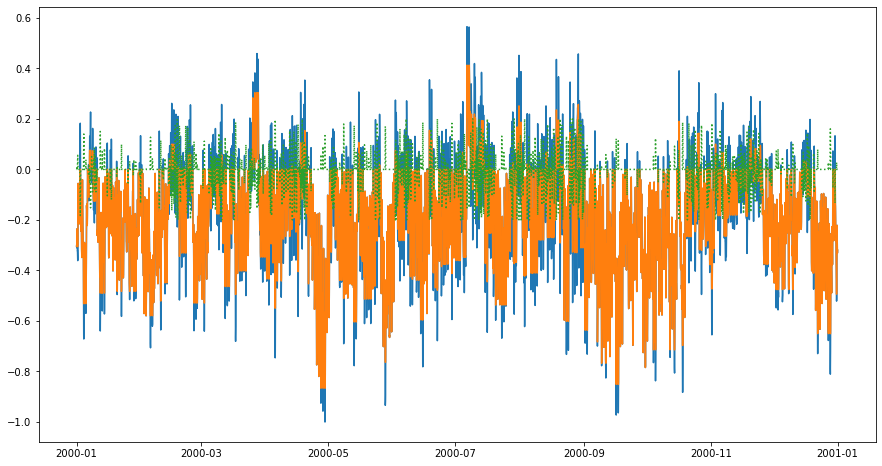

In [11]:
plt.figure(figsize=(15, 8))
plt.plot(df_residual.loc[df_residual.index.year==2000, 1])
plt.plot(df.loc[df.index.year==2000, 1])
plt.plot(df_charge.loc[df.index.year==2000, 1], linestyle=':')

plt.show()

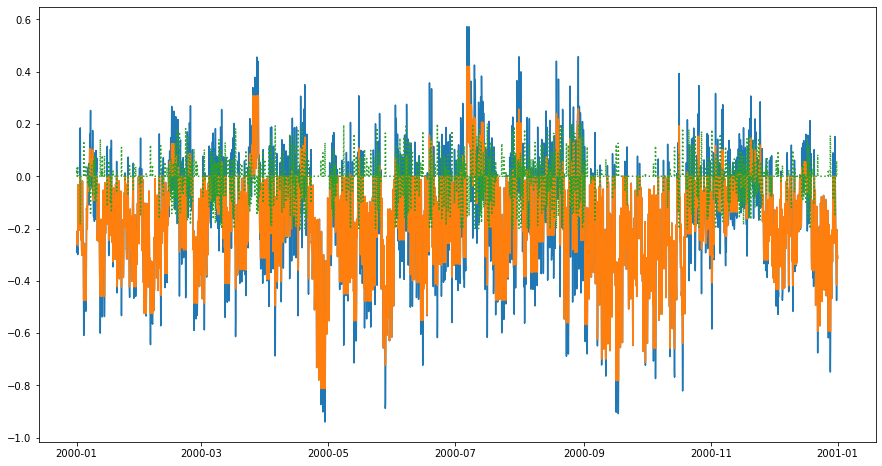

In [12]:
plt.figure(figsize=(15, 8))
plt.plot(df_residual.loc[df_residual.index.year==2000, 2])
plt.plot(df.loc[df.index.year==2000, 2])
plt.plot(df_charge.loc[df.index.year==2000, 2], linestyle=':')

plt.show()

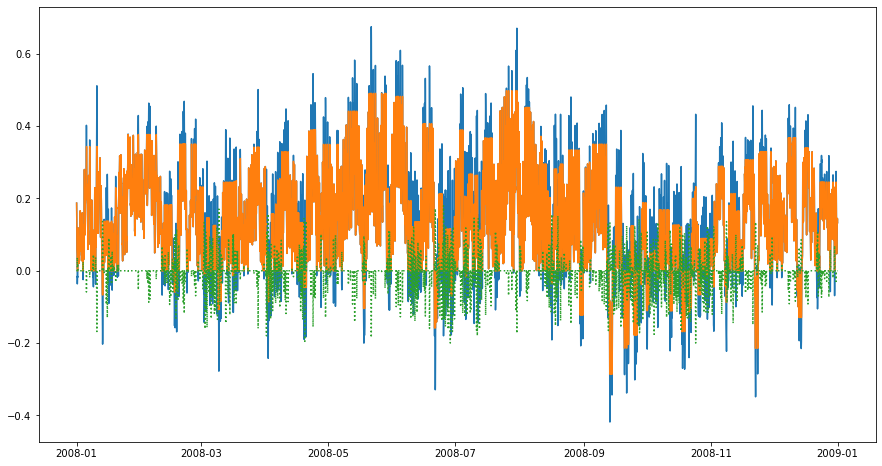

In [13]:
plt.figure(figsize=(15, 8))
plt.plot(df_residual.loc[df_residual.index.year==2008, 12])
plt.plot(df.loc[df.index.year==2008, 12])
plt.plot(df_charge.loc[df.index.year==2008, 12], linestyle=':')

plt.show()

In [14]:
df.describe()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
count,87672.000000,8.767200e+04,8.767200e+04,8.767200e+04,8.767200e+04,87672.000000,87672.000000,8.767200e+04,87672.000000,87672.000000,8.767200e+04,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,8.767200e+04,8.767200e+04
mean,-0.178878,-1.551941e-01,-1.473221e-01,-1.341609e-01,-1.081782e-01,-0.067070,-0.039017,2.517163e-03,0.033537,0.058959,8.064328e-02,0.117670,0.149179,0.177045,0.203005,0.251692,2.982206e-01,3.358035e-01
std,0.201536,1.929103e-01,1.895237e-01,1.847118e-01,1.760554e-01,0.164451,0.157367,1.482678e-01,0.142567,0.138590,1.357057e-01,0.131737,0.129360,0.127401,0.125482,0.120951,1.149120e-01,1.118112e-01
min,-0.950466,-8.792591e-01,-8.505161e-01,-8.063107e-01,-7.364869e-01,-0.665580,-0.621959,-5.551087e-01,-0.501250,-0.454615,-4.115789e-01,-0.339083,-0.269104,-0.218597,-0.174712,-0.082752,-1.339083e-10,-1.605363e-10
25%,-0.312173,-2.844278e-01,-2.752512e-01,-2.593249e-01,-2.270919e-01,-0.176503,-0.140873,-8.690827e-02,-0.045809,-0.011609,-1.441366e-09,0.005747,0.046828,0.081124,0.111614,0.167082,2.186345e-01,2.603596e-01
50%,-0.163009,-1.395697e-01,-1.321037e-01,-1.190892e-01,-9.151011e-02,-0.045777,-0.012943,4.432433e-11,0.005438,0.036693,6.193982e-02,0.105094,0.140711,0.170905,0.198116,0.247339,2.934670e-01,3.319504e-01
75%,-0.010502,-2.211565e-09,-1.969391e-10,8.988796e-11,1.885702e-09,0.017144,0.046153,9.063071e-02,0.122252,0.147757,1.704485e-01,0.207621,0.237432,0.263830,0.287883,0.332421,3.742388e-01,4.084418e-01
max,0.423661,4.305998e-01,4.338056e-01,4.389193e-01,4.477962e-01,0.464859,0.476783,4.932594e-01,0.515676,0.531359,5.416921e-01,0.556865,0.576437,0.589962,0.626660,0.665590,7.528167e-01,7.756434e-01


In [15]:
df_residual.describe()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
count,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000
mean,-0.178878,-0.155194,-0.147322,-0.134161,-0.108178,-0.067070,-0.039017,0.002517,0.033537,0.058959,0.080643,0.117670,0.149179,0.177045,0.203005,0.251692,0.298221,0.335803
std,0.222879,0.214577,0.211247,0.206651,0.198863,0.188234,0.181530,0.172309,0.165692,0.160380,0.155912,0.148516,0.142407,0.137061,0.132203,0.123434,0.115486,0.112029
min,-1.122483,-1.047642,-1.015986,-0.968644,-0.893355,-0.790640,-0.734217,-0.655466,-0.599995,-0.555736,-0.516944,-0.450733,-0.393860,-0.342037,-0.293412,-0.204004,-0.119219,-0.087619
25%,-0.321616,-0.294876,-0.285622,-0.270678,-0.240383,-0.192943,-0.160696,-0.113411,-0.078071,-0.049171,-0.024614,0.017047,0.052551,0.083858,0.112895,0.167379,0.218709,0.260360
50%,-0.172636,-0.150913,-0.143875,-0.132268,-0.107900,-0.067477,-0.040548,0.000052,0.030567,0.055687,0.077203,0.114081,0.145463,0.173174,0.199140,0.247393,0.293477,0.331950
75%,-0.028362,-0.009858,-0.004349,0.005373,0.025989,0.058914,0.082139,0.117064,0.143440,0.165217,0.183666,0.215543,0.242995,0.267184,0.289770,0.332792,0.374239,0.408442
max,0.619022,0.624168,0.626375,0.629953,0.636556,0.643569,0.650214,0.661827,0.670470,0.678199,0.684221,0.695381,0.704782,0.713639,0.722018,0.737825,0.752817,0.781360


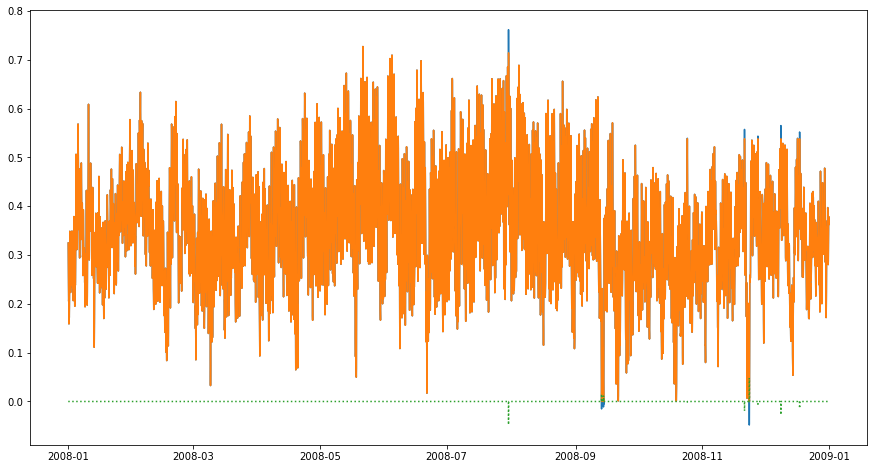

In [16]:
plt.figure(figsize=(15, 8))
plt.plot(df_residual.loc[df_residual.index.year==2008, 18])
plt.plot(df.loc[df.index.year==2008, 18])
plt.plot(df_charge.loc[df.index.year==2008, 18], linestyle=':')

plt.show()